In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from datetime import datetime
import urllib
import time
import random
import requests
import io
import matplotlib.pyplot as plt
from copy import copy

## Парсер

In [ ]:
class Finam_parser:
    def __init__(self):
        finam_symbols = urllib.request.urlopen('http://www.finam.ru/cache/icharts/icharts.js').readlines()
        str_id = str(finam_symbols[0])
        str_code = str(finam_symbols[2])
        str_markets = str(finam_symbols[3])

        start = str(str_code).find("[\'") + 2
        end = str_code.find("\']")
        self.names = str_code[start : end].split('\',\'') #список всех инструментов
        self.ids = str_id[str_id.find('[') + 1 : str_id.find(']')].split(',') #их коды
        self.markets = [int(el) for el in str_markets[str_markets.find('[') + 1 : str_markets.find(']')].split(',')] #биржи

    def data_downloader(self, num_of_years=5, detalization='daily', stocks=[1, 16, 517], e = ".csv", start_date_str=None, end_date_str=None, download_all=False, min_record=25):
        """ num_of_years - длина периода сбора данных
        stocks - список закодированных бирж 1 - мосбиржа, 16-мосбиржа архив, 517 - спб
        detalization - насколько подробные данные (по часам/дням) {'tick': 1, 'min': 2, '5min': 3, '10min': 4, '15min': 5, '30min': 6, 'hour': 7, 'daily': 8, 'week': 9, 'month': 10}
        e - формат таблицы
        start/end_date_str - границы в формате %d.%m.%Y
        download=True - скачивать данные за весь возможный период
        min_record - минимальное количество записей акции для добавления в данные
        """
        periods = {'tick': 1, 'min': 2, '5min': 3, '10min': 4, '15min': 5, '30min': 6, 'hour': 7, 'daily': 8, 'week': 9, 'month': 10}
        period = periods[detalization]
        FINAM_URL = "http://export.finam.ru/export9.out?"
    
        if (start_date_str==None and end_date_str==None):
            end_date = datetime.today().date()
            start_date = datetime.strptime(str(end_date.day)+ '.' + str(end_date.month)+ '.' + str(end_date.year - num_of_years), "%d.%m.%Y").date()
        else: 
            start_date = datetime.strptime(start_date_str, "%d.%m.%Y").date()
            end_date = datetime.strptime(end_date_str, "%d.%m.%Y").date()
        if download_all:
            start_date = datetime.strptime('01.01.1979', "%d.%m.%Y").date()
            end_date = datetime.today().date()

        all_tickets = pd.DataFrame({'Date&Time': [], 'Ticker': [], 'Per': [], 'Open': [], 'High': [], 'Low': [], 'Close': [], 'Volume': []})
        success = 0
        error_403 = 0
        empty_files = 0
        small_files = 0
        total = 0
        for stock in stocks:
            print('Номер биржи:', stock)
            id_stock = [i for i, val in enumerate(self.markets) if val==stock]
            for id in id_stock:
                market = stock
                symbol_code = self.ids[id] #Номер инструмента
                symbol = self.names[id] #Тикер инструмента
                apply = 0
                name_of_table = "table"
                #​ Формируем строку с параметрами запроса:
                params = urllib.parse.urlencode([
                                                ('market', market),
                                                ('em', symbol_code),
                                                ('code', symbol),
                                                ('apply', apply), #хз что это
                                                ('df', start_date.day), # df, mf, yf, from, dt, mt, yt, to – это параметры времени.
                                                ('mf', start_date.month - 1),
                                                ('yf', start_date.year),
                                                ('from', start_date),
                                                ('dt', end_date.day),
                                                ('mt', end_date.month - 1),
                                                ('yt', end_date.year),
                                                ('to', end_date),
                                                ('p', period), # p — период котировок (тики, 1 мин., 5 мин., 10 мин., 15 мин., 30 мин., 1 час, 1 день, 1 неделя, 1 месяц)
                                                ('f', symbol_code + '_' + str(start_date)),
                                                ('e', e), # e – расширение получаемого файла; возможны варианты — .txt либо .csv
                                                ('cn', symbol),
                                                ('dtf', '1'), # dtf — формат даты (1 — ггггммдд, 2 — ггммдд, 3 — ддммгг, 4 — дд/мм/гг, 5 — мм/дд/гг)
                                                ('tmf', '1'), # tmf — формат времени (1 — ччммсс, 2 — ччмм, 3 — чч: мм: сс, 4 — чч: мм)
                                                ('MSOR', '0'), # MSOR — выдавать время (0 — начала свечи, 1 — окончания свечи)
                                                ('mstime', 'on'),
                                                ('mstimever', '1'), # mstimever — выдавать время (НЕ московское — mstimever=0; московское — mstime='on', mstimever='1')
                                                ('sep', '3'), # sep — параметр разделитель полей (1 — запятая (,), 2 — точка (.), 3 — точка с запятой (;), 4 — табуляция (»), 5 — пробел ( ))
                                                ('sep2', '1'), # sep2 — параметр разделитель разрядов (1 — нет, 2 — точка (.), 3 — запятая (,), 4 — пробел ( ), 5 — кавычка ('))
                                                ('datf', '1'), # datf — Перечень получаемых данных (#1 — TICKER, PER, DATE, TIME, OPEN, HIGH, LOW, CLOSE, VOL; #2 — TICKER, PER, DATE, TIME, OPEN, HIGH, LOW, CLOSE; #3 — TICKER, PER, DATE, TIME, CLOSE, VOL; #4 — TICKER, PER, DATE, TIME, CLOSE; #5 — DATE, TIME, OPEN, HIGH, LOW, CLOSE, VOL; #6 — DATE, TIME, LAST, VOL, ID, OPER).
                                                ('at', '1'), # at — добавлять заголовок в файл (0 — нет, 1 — да)
                                                # ('fsp', '1'), #- заполнять периоды без сделок
                    ])

                url = FINAM_URL + params # Полная строка адреса со всеми параметрами.
                header = {
                'accept':'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3',
                'accept-encoding':'gzip, deflate, br',
                'accept-language':'ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7',
                'cache-control':'no-cache',
                'dnt': '1',
                'pragma': 'no-cache',
                'sec-fetch-mode': 'navigate',
                'sec-fetch-site': 'none',
                'sec-fetch-user': '?1',
                'upgrade-insecure-requests': '1',
                'user-agent': 'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/76.0.3809.100 Safari/537.36'}
                #print(url)
                #Соединяемся с сервером, получаем данные и выполняем их разбор:

                try:
                    total += 1
                    session = requests.Session()
                    session.headers = header
                    r = session.get(url)   
                    data = pd.read_csv(io.StringIO(r.text), header=0, parse_dates={'Date&Time': [2, 3]}, sep=';').sort_index()
                    data.columns = ['Date&Time', 'Ticker', 'Per', 'Open', 'High', 'Low', 'Close', 'Volume'] # Заголовки столбцов
                    if len(data)>=min_record:
                        all_tickets = pd.concat([all_tickets, data], ignore_index=True)
                        success += 1
                    else:
                        small_files += 1
                #except HTTPError as e:
                except urllib.error.HTTPError:
                    error_403 += 1
                except pd.io.common.EmptyDataError:
                    empty_files += 1
                except pd.io.common.ParserError:
                    empty_files += 1         
            print('success:', success)
            print('error_403:', error_403)
            print('empty_files:', empty_files)
            print('small_files:', small_files)
            print('In total:', total)
        return all_tickets

In [ ]:
finam_parser = Finam_parser()
data = finam_parser.data_downloader(download_all=True)

Номер биржи: 1
success: 288
error_403: 0
empty_files: 12
small_files: 4
In total: 304
Номер биржи: 16
success: 599
error_403: 0
empty_files: 581
small_files: 135
In total: 1315
Номер биржи: 517
success: 816
error_403: 0
empty_files: 995
small_files: 139
In total: 1950


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 991016 entries, 0 to 991015
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date&Time  991016 non-null  object 
 1   Ticker     991016 non-null  object 
 2   Per        991016 non-null  object 
 3   Open       991016 non-null  float64
 4   High       991016 non-null  float64
 5   Low        991016 non-null  float64
 6   Close      991016 non-null  float64
 7   Volume     991016 non-null  float64
dtypes: float64(5), object(3)
memory usage: 68.0+ MB


## Прежде чем масштабировать данные, нужно разделить их на обучающую и тестовую выборки

In [ ]:
data = pd.read_csv('/content/drive/My Drive/finam_data_1_16_517.csv', index_col=0)

In [ ]:
test_data = data[data['Date&Time'] >= '2018-11-09']
val_data = data[(data['Date&Time'] > '2018-05-09') & (data['Date&Time'] <= '2018-11-09')]
train_data = data[data['Date&Time'] < '2018-05-09']

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798479 entries, 0 to 990501
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date&Time  798479 non-null  object 
 1   Ticker     798479 non-null  object 
 2   Per        798479 non-null  object 
 3   Open       798479 non-null  float64
 4   High       798479 non-null  float64
 5   Low        798479 non-null  float64
 6   Close      798479 non-null  float64
 7   Volume     798479 non-null  float64
dtypes: float64(5), object(3)
memory usage: 54.8+ MB


In [ ]:
val_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53876 entries, 4719 to 990502
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date&Time  53876 non-null  object 
 1   Ticker     53876 non-null  object 
 2   Per        53876 non-null  object 
 3   Open       53876 non-null  float64
 4   High       53876 non-null  float64
 5   Low        53876 non-null  float64
 6   Close      53876 non-null  float64
 7   Volume     53876 non-null  float64
dtypes: float64(5), object(3)
memory usage: 3.7+ MB


In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246204 entries, 4719 to 991015
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date&Time  246204 non-null  object 
 1   Ticker     246204 non-null  object 
 2   Per        246204 non-null  object 
 3   Open       246204 non-null  float64
 4   High       246204 non-null  float64
 5   Low        246204 non-null  float64
 6   Close      246204 non-null  float64
 7   Volume     246204 non-null  float64
dtypes: float64(5), object(3)
memory usage: 16.9+ MB


In [ ]:
train_data.describe()

,Open,High,Low,Close,Volume
count,798479.000000,798479.000000,798479.000000,798479.000000,7.984790e+05
mean,1173.593619,1192.685482,1156.150842,1175.916475,1.649058e+08
std,9024.737329,9155.245646,8899.520787,9038.817384,2.528803e+09
min,0.000760,0.000780,0.000490,0.000740,0.000000e+00
25%,2.000000,2.050000,1.948300,2.000000,2.473000e+03
50%,36.090000,36.800000,35.410000,36.080000,7.680000e+04
75%,190.250000,194.000000,187.000000,190.500000,9.400000e+05
max,231000.000000,235700.000000,220100.000000,231000.000000,2.229481e+11


In [ ]:
val_data.describe()

,Open,High,Low,Close,Volume
count,53876.000000,53876.000000,53876.000000,53876.000000,5.387600e+04
mean,1140.403039,1151.123045,1128.154415,1140.423885,6.277913e+07
std,10069.038972,10151.953147,9965.947449,10070.043168,1.236048e+09
min,0.001990,0.002005,0.001985,0.001995,1.000000e+00
25%,13.100000,13.315000,12.750000,13.000000,2.113875e+04
50%,69.900000,70.630000,69.100000,69.885000,2.492665e+05
75%,166.650000,168.585000,164.415000,166.547500,8.700252e+05
max,176050.000000,177300.000000,174600.000000,176450.000000,1.275494e+11


In [ ]:
test_data.describe()

,Open,High,Low,Close,Volume
count,246204.000000,246204.000000,246204.000000,246204.000000,2.462040e+05
mean,1140.394003,1156.959979,1124.426540,1140.917682,9.857804e+07
std,9012.548933,9109.129313,8908.070219,9013.419069,2.061279e+09
min,0.001990,0.002005,0.001985,0.001995,1.000000e+00
25%,13.780000,14.140000,13.410000,13.790000,1.270000e+04
50%,68.940000,69.900000,67.930000,68.930000,2.459035e+05
75%,172.600000,174.932500,170.330000,172.600000,9.913615e+05
max,179950.000000,183200.000000,177900.000000,179850.000000,2.336690e+11


## Добавление признаков из технического анализа в модель

In [ ]:

def add_tech_analysis(data):
  data_ta = pd.DataFrame([])

  def add_ta(df):
    df['SMA'] = df['Close'].rolling(window=10, min_periods=1).mean()
    df['EMA'] = df['Close'].ewm(span=10, min_periods=1).mean()
    df['MACD'] = df['Close'].ewm(span=12, min_periods=1).mean() - df['Close'].ewm(span=26, min_periods=1).mean()
    nonlocal data_ta
    data_ta = data_ta.append(df)
  
  data.groupby('Ticker').apply(add_ta)
  return data_ta.drop_duplicates()

In [ ]:

train_data_ta = add_tech_analysis(train_data)

In [ ]:

test_data_ta = add_tech_analysis(test_data)
val_data_ta = add_tech_analysis(val_data)

In [ ]:

train_data_ta

,Date&Time,Ticker,Per,Open,High,Low,Close,Volume,SMA,EMA,MACD
813450,2016-11-25,A,D,44.72,44.72,44.72,44.72,2.0,44.720,44.720000,0.000000
813451,2016-11-29,A,D,43.60,44.02,43.60,44.00,68.0,44.360,44.324000,-0.016154
813452,2016-12-01,A,D,43.31,43.39,43.28,43.28,6.0,44.000,43.904319,-0.042910
813453,2017-01-09,A,D,48.30,48.30,48.24,48.24,8.0,45.060,45.332733,0.125051
813454,2017-01-12,A,D,48.33,48.36,48.32,48.34,22.0,45.716,46.196037,0.217665
...,...,...,...,...,...,...,...,...,...,...,...
168728,2018-11-01,ZVEZ,D,4.83,4.89,4.76,4.87,168000.0,4.933,4.957648,-0.081296
168729,2018-11-02,ZVEZ,D,4.89,4.91,4.80,4.90,80000.0,4.937,4.947166,-0.081242
168730,2018-11-06,ZVEZ,D,4.83,4.91,4.83,4.89,37000.0,4.942,4.936772,-0.081072
168731,2018-11-07,ZVEZ,D,4.87,5.19,4.84,4.92,123000.0,4.954,4.933723,-0.077621


In [ ]:

test_data_ta

,Date&Time,Ticker,Per,Open,High,Low,Close,Volume,SMA,EMA,MACD
813745,2018-05-09,A,D,67.370,68.400,67.170,68.130,313432.0,68.1300,68.130000,0.000000
813746,2018-05-10,A,D,68.190,68.880,68.180,68.870,194775.0,68.5000,68.537000,0.016603
813747,2018-05-11,A,D,69.150,69.600,68.920,69.460,216005.0,68.8200,68.908040,0.039451
813748,2018-05-12,A,D,69.990,69.990,69.550,69.550,200.0,69.0025,69.119537,0.052125
813749,2018-05-14,A,D,70.050,70.430,63.950,64.010,489761.0,68.0040,67.652728,-0.162534
...,...,...,...,...,...,...,...,...,...,...,...
169164,2020-08-03,ZVEZ,D,4.630,5.200,4.565,4.580,1126000.0,4.5560,4.560081,0.015835
169165,2020-08-04,ZVEZ,D,4.575,4.730,4.560,4.590,89000.0,4.5620,4.565521,0.017348
169166,2020-08-05,ZVEZ,D,4.565,4.645,4.560,4.645,25000.0,4.5730,4.579972,0.022723
169167,2020-08-06,ZVEZ,D,4.645,4.655,4.480,4.555,336000.0,4.5715,4.575431,0.019496


In [ ]:

val_data_ta

,Date&Time,Ticker,Per,Open,High,Low,Close,Volume,SMA,EMA,MACD
813746,2018-05-10,A,D,68.19,68.88,68.18,68.87,194775.0,68.870000,68.870000,0.000000
813747,2018-05-11,A,D,69.15,69.60,68.92,69.46,216005.0,69.165000,69.194500,0.013237
813748,2018-05-12,A,D,69.99,69.99,69.55,69.55,200.0,69.293333,69.337409,0.019658
813749,2018-05-14,A,D,70.05,70.43,63.95,64.01,489761.0,67.972500,67.582265,-0.177923
813750,2018-05-15,A,D,64.29,65.30,60.84,62.74,2116588.0,66.926000,66.192182,-0.332077
...,...,...,...,...,...,...,...,...,...,...,...
168729,2018-11-02,ZVEZ,D,4.89,4.91,4.80,4.90,80000.0,4.937000,4.947166,-0.081278
168730,2018-11-06,ZVEZ,D,4.83,4.91,4.83,4.89,37000.0,4.942000,4.936772,-0.081104
168731,2018-11-07,ZVEZ,D,4.87,5.19,4.84,4.92,123000.0,4.954000,4.933723,-0.077651
168732,2018-11-08,ZVEZ,D,4.88,5.00,4.86,4.91,98000.0,4.969000,4.929410,-0.074858


## Масштабирование данных

In [ ]:
def scale(data, columns=['Open', 'High', 'Low', 'Close', 'Volume', 'SMA', 'EMA', 'MACD']):

  def calculate_rel(df, columns):
    result = df.copy()
    #print(result)#.loc[:, columns])
    result[columns] = np.vstack((np.reshape(np.array([1 for i in range(len(columns))]), (1, -1)), df[columns].to_numpy()[1:] / df[columns].to_numpy()[:-1]))
    return result

  result = data.groupby('Ticker', as_index=False).apply(calculate_rel, columns=columns).reset_index().set_index('level_1').drop('level_0', axis='columns')
  return result.drop(result[result.Volume == float('inf')].index, axis=0)

In [ ]:
scaled_train_data = scale(train_data, columns=['Open', 'High', 'Low', 'Close', 'Volume'])
scaled_val_data = scale(val_data, columns=['Open', 'High', 'Low', 'Close', 'Volume'])
scaled_test_data = scale(test_data, columns=['Open', 'High', 'Low', 'Close', 'Volume'])

In [ ]:
scaled_val_data

,Date&Time,Ticker,Per,Open,High,Low,Close,Volume
level_1,,,,,,,,
813746,2018-05-10,A,D,1.000000,1.000000,1.000000,1.000000,1.000000
813747,2018-05-11,A,D,1.014078,1.010453,1.010854,1.008567,1.108998
813748,2018-05-12,A,D,1.012148,1.005603,1.009141,1.001296,0.000926
813749,2018-05-14,A,D,1.000857,1.006287,0.919482,0.920345,2448.805000
813750,2018-05-15,A,D,0.917773,0.927162,0.951368,0.980159,4.321675
...,...,...,...,...,...,...,...,...
168729,2018-11-02,ZVEZ,D,1.012422,1.004090,1.008403,1.006160,0.476190
168730,2018-11-06,ZVEZ,D,0.987730,1.000000,1.006250,0.997959,0.462500
168731,2018-11-07,ZVEZ,D,1.008282,1.057026,1.002070,1.006135,3.324324


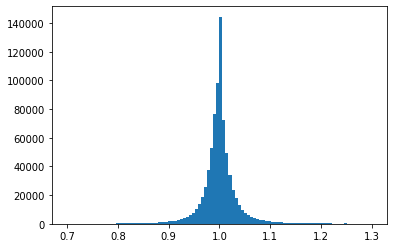

In [ ]:
_ = plt.hist(scaled_train_data['Close'], range=(0.7, 1.3), bins=100)

## Преобразование датасетов

In [ ]:
def fast_data_transformer(data, look_back=20, look_forward=5, y_interval=1, x_interval=1, threshold=0.03):
    """ look_back - сколько прошедших дней используем для предсказания
    look_forward - сколько предсказываем
    Возвращаем тензоры заданной размерности: X - (количество строчек в данных, количество дней в одной строке (look_back), количество признаков)
    y - (количество строчек в данных, сколько дней предсказываем (look_forward))"""
    def constructor(row, df):
        if ((row.name >= look_back) & (row.name <= len(df) - look_forward)):
            X.append(np.reshape(np.array(df.iloc[row.name - look_back : row.name : x_interval]), (int(look_back / x_interval), -1)))
            dev = np.prod(df.iloc[row.name : row.name + look_forward : y_interval].Close)
            y.append(1 if dev > 1 + threshold else 2 if dev < 1 - threshold else 0)
        
    def applier(df):
        df = df.reset_index(drop=True)
        df.apply(constructor, df=df, axis=1)

    X = []
    y = []
    data.groupby('Ticker', as_index=False).apply(applier)
    
    return torch.tensor(np.array(X)[:, :, -5 :].astype(float)), torch.tensor(np.array(y))

Класс 1 - rise, класс 2 - fall, класс 0 - fair

In [ ]:
%%time
X_train, y_train = fast_data_transformer(scaled_train_data)

CPU times: user 4min 42s, sys: 5.31 s, total: 4min 47s
Wall time: 4min 47s


In [ ]:
torch.save(X_train, '/content/drive/MyDrive/x_train.pt')
torch.save(y_train, '/content/drive/MyDrive/y_train.pt')

In [ ]:
X_test, y_test = fast_data_transformer(scaled_test_data)

In [ ]:
torch.save(X_test, '/content/drive/MyDrive/x_test.pt')
torch.save(y_test, '/content/drive/MyDrive/y_test.pt')

In [ ]:
X_val, y_val = fast_data_transformer(scaled_val_data)

In [ ]:
torch.save(X_val, '/content/drive/MyDrive/x_val.pt')
torch.save(y_val, '/content/drive/MyDrive/y_val.pt')

In [ ]:
y_val

tensor([0, 0, 0,  ..., 0, 0, 0])

In [ ]:
y_train.shape

torch.Size([779270])

Посмотрим на распределение ответов на обучающей выборке 

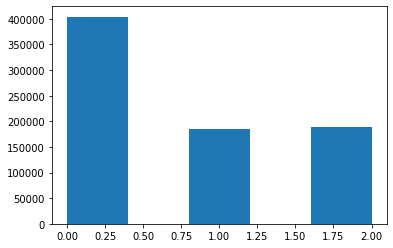

In [ ]:
_ = plt.hist(y_train, bins=5)

## Андерсемплинг

In [ ]:
np.random.seed(42)

In [ ]:
def undersample(X, y, undersample=2):
  indices = np.where(y == 0)[0]
  indices_to_drop = np.random.choice(indices, size=indices.shape[0] // undersample)
  return X[np.array(list(set(np.arange(X.shape[0])) - set(indices_to_drop)))], y[np.array(list(set(np.arange(X.shape[0])) - set(indices_to_drop)))]

In [ ]:
X_train_undersampled, y_train_undersampled = undersample(X_train, y_train)

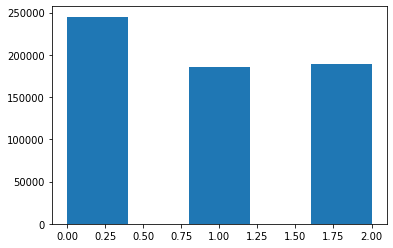

In [ ]:
_ = plt.hist(y_train_undersampled, bins=5)

In [ ]:
torch.save(X_train_undersampled, '/content/drive/My Drive/x_train_undersampled.pt')

In [ ]:
torch.save(y_train_undersampled, '/content/drive/My Drive/y_train_undersampled.pt')

In [ ]:
X_train_undersampled = torch.load('/content/drive/My Drive/x_train_undersampled.pt')

In [ ]:
y_train_undersampled = torch.load('/content/drive/My Drive/y_train_undersampled.pt')

In [ ]:
X_test = torch.load('/content/drive/My Drive/x_test.pt')

In [ ]:
y_test = torch.load('/content/drive/My Drive/y_test.pt')

In [ ]:
X_val = torch.load('/content/drive/My Drive/x_val.pt')

In [ ]:
y_val = torch.load('/content/drive/My Drive/y_val.pt')

In [ ]:
X_train_undersampled.shape

torch.Size([620111, 20, 5])

# Gramian Angular Field + CNN

In [ ]:
!pip install pyts

     |████████████████████████████████| 2.5MB 17.7MB/s 


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
/usr/local/lib/python3.6/dist-packages/mpl_toolkits/axes_grid1/axes_grid.py:51: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from .colorbar import Colorbar


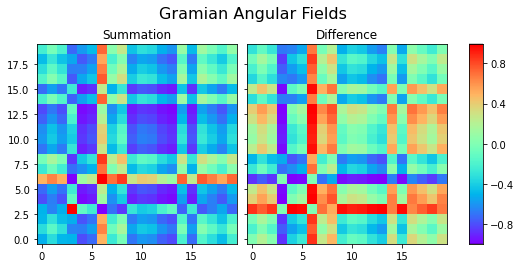

In [ ]:
gasf = GramianAngularField(image_size=20, method='summation')
X_gasf = gasf.fit_transform(X_val[:, :, 3])
gadf = GramianAngularField(image_size=20, method='difference')
X_gadf = gadf.fit_transform(X_val[:, :, 3])

# Show the images for the first time series
fig = plt.figure(figsize=(8, 4))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(1, 2),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.3,
                 )
images = [X_gasf[0], X_gadf[0]]
titles = ['Summation', 'Difference']
for image, title, ax in zip(images, titles, grid):
    im = ax.imshow(image, cmap='rainbow', origin='lower')
    ax.set_title(title, fontdict={'fontsize': 12})
ax.cax.colorbar(im)
ax.cax.toggle_label(True)
plt.suptitle('Gramian Angular Fields', y=0.98, fontsize=16)
plt.show()

In [ ]:
gadf = GramianAngularField(image_size=20, method='difference')

In [ ]:
X_train_gadf = gadf.fit_transform(X_train_undersampled[:, :, 3])
X_val_gadf = gadf.fit_transform(X_val[:, :, 3])
X_test_gadf = gadf.fit_transform(X_test[:, :, 3])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  app.launch_new_instance()


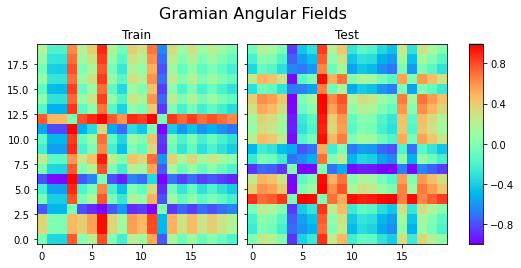

In [ ]:
fig = plt.figure(figsize=(8, 4))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(1, 2),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.3,
                 )
images = [X_train_gadf[0], X_test_gadf[0]]
titles = ['Train', 'Test']
for image, title, ax in zip(images, titles, grid):
    im = ax.imshow(image, cmap='rainbow', origin='lower')
    ax.set_title(title, fontdict={'fontsize': 12})
ax.cax.colorbar(im)
ax.cax.toggle_label(True)
plt.suptitle('Gramian Angular Fields', y=0.98, fontsize=16)
plt.show()

In [ ]:
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train_gadf).reshape(-1, 1, 20, 20).float().cuda(), y_train_undersampled.cuda())
val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val_gadf).reshape(-1, 1, 20, 20).float().cuda(), y_val.cuda())
test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test_gadf).reshape(-1, 1, 20, 20).float().cuda())

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=256, 
                                           shuffle=False)

In [ ]:
from tqdm import tqdm, tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import time

In [ ]:
DEVICE = torch.device("cuda")
use_gpu = True

In [ ]:
import torch.nn.functional as F  # Functional
class ModelCnn(nn.Module):
  
    def __init__(self, n_classes):
        
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=2),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=1)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=3, stride=1)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(2 * 2 * 128, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        
        self.fc3 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        
        self.fc4 = nn.Sequential(
            nn.Linear(1024, n_classes)
        )  

  
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        #x = self.conv4(x)
        #x = self.conv5(x)
        

        #x = F.interpolate(x, size=(2, 2), mode='bilinear')  # resize to the size expected by the linear unit
        x = x.view(x.size(0), 2 * 2 * 128)
    
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        x = self.fc4(x)
        
        return x

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(dataset=train_files, 
                                           batch_size=batch_size, 
                                           shuffle=False)
    val_loader = DataLoader(dataset=val_files, 
                                           batch_size=batch_size, 
                                           shuffle=False)
    

    #dataset_sizes = {'train': len(new_train_dataset), 'val':len(val_dataset) }

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            scheduler.step(val_loss)
            
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs[0].to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
model_cnn = ModelCnn(3).to(DEVICE) 

Запустим обучение сети.

In [ ]:
history = train(train_dataset, val_dataset, model=model_cnn, epochs=30, batch_size=256)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

loss 1.1028608742392196


epoch:   3%|▎         | 1/30 [00:21<10:19, 21.36s/it]


Epoch 001 train_loss: 1.1029     val_loss 1.1455 train_acc 0.3939 val_acc 0.3212
loss 1.0892532090382512


epoch:   7%|▋         | 2/30 [00:42<09:53, 21.20s/it]


Epoch 002 train_loss: 1.0893     val_loss 1.1288 train_acc 0.3990 val_acc 0.2940
loss 1.0882844972576948


epoch:  10%|█         | 3/30 [01:02<09:26, 20.99s/it]


Epoch 003 train_loss: 1.0883     val_loss 1.1154 train_acc 0.3999 val_acc 0.3416
loss 1.0872497482048171


epoch:  13%|█▎        | 4/30 [01:23<09:00, 20.80s/it]


Epoch 004 train_loss: 1.0872     val_loss 1.1285 train_acc 0.4010 val_acc 0.3056
loss 1.086559078159547


epoch:  17%|█▋        | 5/30 [01:43<08:37, 20.69s/it]


Epoch 005 train_loss: 1.0866     val_loss 1.1025 train_acc 0.4021 val_acc 0.3765
loss 1.0855873537747276


epoch:  20%|██        | 6/30 [02:03<08:15, 20.63s/it]


Epoch 006 train_loss: 1.0856     val_loss 1.1058 train_acc 0.4041 val_acc 0.3572
loss 1.084879171206201


epoch:  23%|██▎       | 7/30 [02:24<07:53, 20.58s/it]


Epoch 007 train_loss: 1.0849     val_loss 1.1139 train_acc 0.4055 val_acc 0.3533
loss 1.0836230151953117


epoch:  27%|██▋       | 8/30 [02:44<07:31, 20.53s/it]


Epoch 008 train_loss: 1.0836     val_loss 1.1157 train_acc 0.4075 val_acc 0.3482
loss 1.0817679971233676


epoch:  30%|███       | 9/30 [03:05<07:11, 20.55s/it]


Epoch 009 train_loss: 1.0818     val_loss 1.1168 train_acc 0.4102 val_acc 0.3513
loss 1.0794659305357148


epoch:  33%|███▎      | 10/30 [03:25<06:50, 20.51s/it]


Epoch 010 train_loss: 1.0795     val_loss 1.1248 train_acc 0.4140 val_acc 0.3492
loss 1.0762465389839517


epoch:  37%|███▋      | 11/30 [03:46<06:29, 20.49s/it]


Epoch 011 train_loss: 1.0762     val_loss 1.1333 train_acc 0.4189 val_acc 0.3368
loss 1.0715114595382877


epoch:  40%|████      | 12/30 [04:06<06:08, 20.47s/it]


Epoch 012 train_loss: 1.0715     val_loss 1.1377 train_acc 0.4255 val_acc 0.3316
loss 1.064813654992413


epoch:  43%|████▎     | 13/30 [04:27<05:47, 20.44s/it]


Epoch 013 train_loss: 1.0648     val_loss 1.1412 train_acc 0.4330 val_acc 0.3250
loss 1.0555936067929785


epoch:  47%|████▋     | 14/30 [04:47<05:27, 20.48s/it]


Epoch 014 train_loss: 1.0556     val_loss 1.1563 train_acc 0.4432 val_acc 0.3215
loss 1.0440416870200373


epoch:  50%|█████     | 15/30 [05:08<05:07, 20.51s/it]


Epoch 015 train_loss: 1.0440     val_loss 1.1671 train_acc 0.4538 val_acc 0.3270
loss 1.0304053322565385


epoch:  53%|█████▎    | 16/30 [05:28<04:45, 20.42s/it]


Epoch 016 train_loss: 1.0304     val_loss 1.1820 train_acc 0.4654 val_acc 0.3361
loss 1.0640530962283545


epoch:  57%|█████▋    | 17/30 [05:48<04:25, 20.41s/it]


Epoch 017 train_loss: 1.0641     val_loss 1.0796 train_acc 0.4299 val_acc 0.4221
loss 1.050695256941874


epoch:  60%|██████    | 18/30 [06:09<04:04, 20.36s/it]


Epoch 018 train_loss: 1.0507     val_loss 1.0795 train_acc 0.4445 val_acc 0.4256
loss 1.0399895998155804


epoch:  63%|██████▎   | 19/30 [06:29<03:42, 20.23s/it]


Epoch 019 train_loss: 1.0400     val_loss 1.0851 train_acc 0.4550 val_acc 0.4236
loss 1.0296147761271806


epoch:  67%|██████▋   | 20/30 [06:48<03:21, 20.13s/it]


Epoch 020 train_loss: 1.0296     val_loss 1.0906 train_acc 0.4647 val_acc 0.4232
loss 1.0191329415989667


epoch:  70%|███████   | 21/30 [07:08<03:00, 20.06s/it]


Epoch 021 train_loss: 1.0191     val_loss 1.0962 train_acc 0.4736 val_acc 0.4248
loss 1.0084064684631142


epoch:  73%|███████▎  | 22/30 [07:28<02:40, 20.10s/it]


Epoch 022 train_loss: 1.0084     val_loss 1.1040 train_acc 0.4823 val_acc 0.4255
loss 0.9972409406362209


epoch:  77%|███████▋  | 23/30 [07:49<02:20, 20.08s/it]


Epoch 023 train_loss: 0.9972     val_loss 1.1132 train_acc 0.4912 val_acc 0.4279
loss 0.9856177480692191


epoch:  80%|████████  | 24/30 [08:08<02:00, 20.02s/it]


Epoch 024 train_loss: 0.9856     val_loss 1.1263 train_acc 0.5002 val_acc 0.4292
loss 0.9735213087483953


epoch:  83%|████████▎ | 25/30 [08:28<01:39, 19.98s/it]


Epoch 025 train_loss: 0.9735     val_loss 1.1405 train_acc 0.5089 val_acc 0.4317
loss 0.9607321994174215


epoch:  87%|████████▋ | 26/30 [08:48<01:19, 19.95s/it]


Epoch 026 train_loss: 0.9607     val_loss 1.1583 train_acc 0.5175 val_acc 0.4339
loss 0.947373371641824


epoch:  90%|█████████ | 27/30 [09:08<00:59, 19.92s/it]


Epoch 027 train_loss: 0.9474     val_loss 1.1784 train_acc 0.5261 val_acc 0.4356
loss 0.933307550121385


epoch:  93%|█████████▎| 28/30 [09:28<00:39, 19.98s/it]


Epoch 028 train_loss: 0.9333     val_loss 1.2049 train_acc 0.5350 val_acc 0.4389
loss 1.0251684843714242


epoch:  97%|█████████▋| 29/30 [09:48<00:20, 20.06s/it]


Epoch 029 train_loss: 1.0252     val_loss 1.0136 train_acc 0.4749 val_acc 0.5117
loss 0.9993842486446786


epoch: 100%|██████████| 30/30 [10:08<00:00, 20.30s/it]


Epoch 030 train_loss: 0.9994     val_loss 1.0170 train_acc 0.4892 val_acc 0.5092


In [ ]:
torch.save(model_cnn.state_dict(), '/content/drive/MyDrive/GADF_CNN.pth')

In [ ]:
model_cnn.load_state_dict(torch.load('/content/drive/MyDrive/GADF_CNN.pth'))

<All keys matched successfully>

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

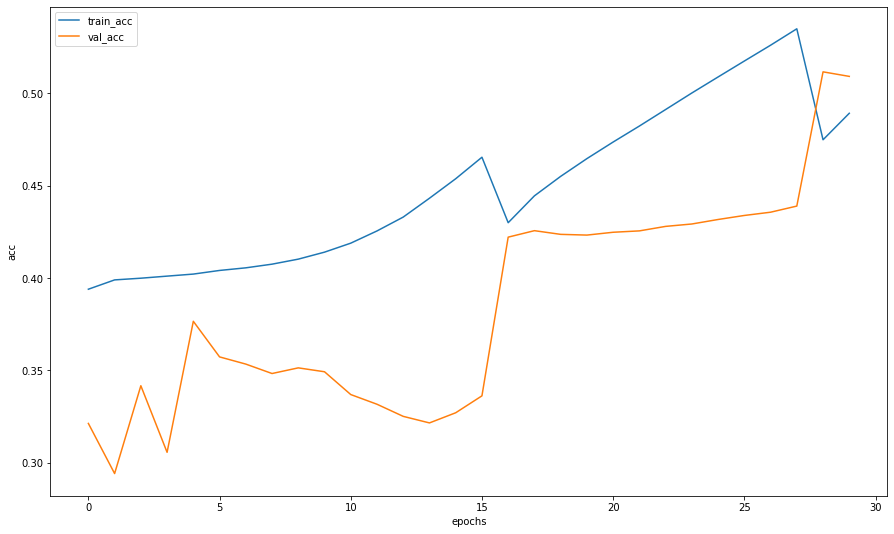

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

In [ ]:
y_prob = predict(model_cnn, test_loader)

In [ ]:
y_pred = np.argmax(predict(model_cnn, test_loader), axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[84620 27032 34295]
 [25092  9971 11012]
 [22250  7424 13526]]


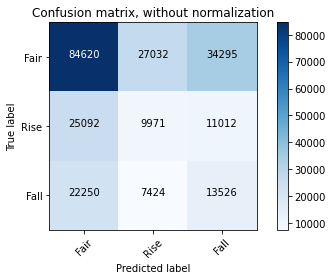

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=False, classes=['Fair', 'Rise', 'Fall'],
                      title='Confusion matrix, without normalization')

In [ ]:
accuracy_score(y_test, y_pred)

0.45963812908656504

In [ ]:
f1_score(y_test, y_pred, labels=[0, 1, 2], average=None)

array([0.61, 0.22, 0.27])

In [ ]:
f1_score(y_test, y_pred, labels=[0, 1, 2], average='macro')

0.3648183167042889

In [ ]:
f1_score(y_test, y_pred, labels=[0, 1, 2], average='weighted')

0.46970286082072155

Бейслайн наивного классификатора

In [ ]:
accuracy_score(y_test, np.zeros(len(y_test)))

0.6204649224987459

In [ ]:
f1_score(y_test, np.zeros(len(y_test)), labels=[0, 1, 2], average=None)

array([0.77, 0.  , 0.  ])

In [ ]:
f1_score(y_test, np.zeros(len(y_test)), labels=[0, 1, 2], average='micro')

0.6204649224987459

In [ ]:
f1_score(y_test, np.zeros(len(y_test)), labels=[0, 1, 2], average='macro')

0.2552621015874848

In [ ]:
f1_score(y_test, np.zeros(len(y_test)), labels=[0, 1, 2], average='weighted')

0.4751435402350372

Попробуем дообучить модель

In [ ]:
history = train(train_dataset, val_dataset, model=model_cnn, epochs=20, batch_size=256)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 0.979609143995692


epoch:   5%|▌         | 1/20 [00:21<06:43, 21.21s/it]


Epoch 001 train_loss: 0.9796     val_loss 1.1389 train_acc 0.5067 val_acc 0.4092
loss 0.9660062106296237


epoch:  10%|█         | 2/20 [00:42<06:20, 21.15s/it]


Epoch 002 train_loss: 0.9660     val_loss 1.1648 train_acc 0.5151 val_acc 0.4128
loss 0.9455615443606449


epoch:  15%|█▌        | 3/20 [01:03<05:58, 21.10s/it]


Epoch 003 train_loss: 0.9456     val_loss 1.1684 train_acc 0.5283 val_acc 0.4236
loss 0.9232729001538519


epoch:  20%|██        | 4/20 [01:24<05:37, 21.06s/it]


Epoch 004 train_loss: 0.9233     val_loss 1.1910 train_acc 0.5425 val_acc 0.4173
loss 0.9024024344463174


epoch:  25%|██▌       | 5/20 [01:44<05:14, 20.99s/it]


Epoch 005 train_loss: 0.9024     val_loss 1.2106 train_acc 0.5558 val_acc 0.4254
loss 0.8812818000960738


epoch:  30%|███       | 6/20 [02:05<04:53, 20.95s/it]


Epoch 006 train_loss: 0.8813     val_loss 1.2168 train_acc 0.5692 val_acc 0.4283
loss 0.861996567136973


epoch:  35%|███▌      | 7/20 [02:26<04:31, 20.85s/it]


Epoch 007 train_loss: 0.8620     val_loss 1.2503 train_acc 0.5800 val_acc 0.4263
loss 0.8437958820737318


epoch:  40%|████      | 8/20 [02:46<04:08, 20.73s/it]


Epoch 008 train_loss: 0.8438     val_loss 1.2691 train_acc 0.5909 val_acc 0.4317
loss 0.8273982094392629


epoch:  45%|████▌     | 9/20 [03:07<03:47, 20.68s/it]


Epoch 009 train_loss: 0.8274     val_loss 1.2951 train_acc 0.6011 val_acc 0.4340
loss 0.8109494340884006


epoch:  50%|█████     | 10/20 [03:27<03:25, 20.55s/it]


Epoch 010 train_loss: 0.8109     val_loss 1.3584 train_acc 0.6112 val_acc 0.4237
loss 0.7966369838199907


epoch:  55%|█████▌    | 11/20 [03:48<03:04, 20.51s/it]


Epoch 011 train_loss: 0.7966     val_loss 1.3453 train_acc 0.6195 val_acc 0.4353
loss 0.7818704241049574


epoch:  60%|██████    | 12/20 [04:08<02:44, 20.52s/it]


Epoch 012 train_loss: 0.7819     val_loss 1.3428 train_acc 0.6279 val_acc 0.4411
loss 0.9205293845224427


epoch:  65%|██████▌   | 13/20 [04:29<02:24, 20.60s/it]


Epoch 013 train_loss: 0.9205     val_loss 1.0419 train_acc 0.5530 val_acc 0.5092
loss 0.8643779882534072


epoch:  70%|███████   | 14/20 [04:49<02:03, 20.53s/it]


Epoch 014 train_loss: 0.8644     val_loss 1.0546 train_acc 0.5855 val_acc 0.5079
loss 0.8216112956362946


epoch:  75%|███████▌  | 15/20 [05:10<01:42, 20.50s/it]


Epoch 015 train_loss: 0.8216     val_loss 1.0712 train_acc 0.6101 val_acc 0.5093
loss 0.7864466459233073


epoch:  80%|████████  | 16/20 [05:30<01:21, 20.40s/it]


Epoch 016 train_loss: 0.7864     val_loss 1.0906 train_acc 0.6304 val_acc 0.5114
loss 0.7550686693446476


epoch:  85%|████████▌ | 17/20 [05:50<01:00, 20.31s/it]


Epoch 017 train_loss: 0.7551     val_loss 1.1157 train_acc 0.6478 val_acc 0.5130
loss 0.7264223097717756


epoch:  90%|█████████ | 18/20 [06:10<00:40, 20.24s/it]


Epoch 018 train_loss: 0.7264     val_loss 1.1433 train_acc 0.6633 val_acc 0.5141
loss 0.6995136657795025


epoch:  95%|█████████▌| 19/20 [06:30<00:20, 20.22s/it]


Epoch 019 train_loss: 0.6995     val_loss 1.1754 train_acc 0.6774 val_acc 0.5144
loss 0.673784758866938


epoch: 100%|██████████| 20/20 [06:50<00:00, 20.54s/it]


Epoch 020 train_loss: 0.6738     val_loss 1.2128 train_acc 0.6910 val_acc 0.5158


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

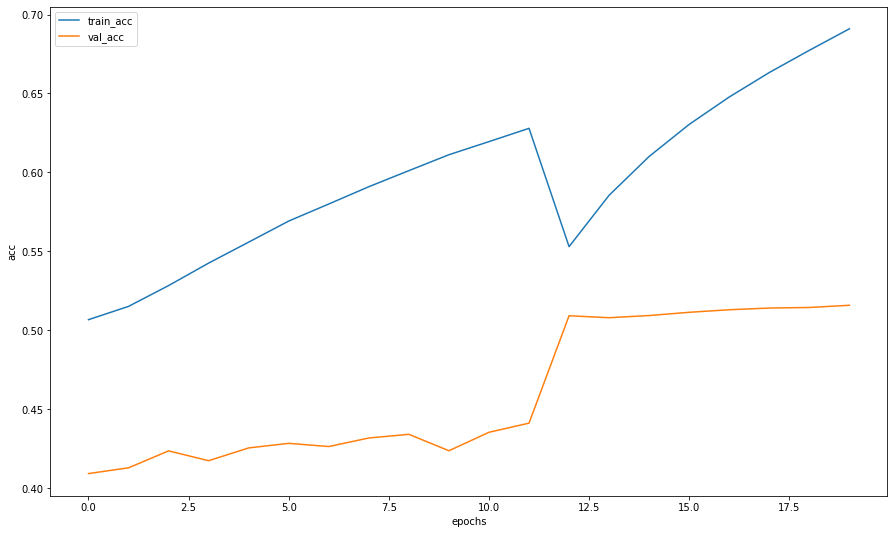

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

In [ ]:
y_pred_50 = np.argmax(predict(model_cnn, test_loader), axis=1)

Confusion matrix, without normalization
[[65562 38366 42019]
 [18827 14100 13148]
 [16956 10160 16084]]


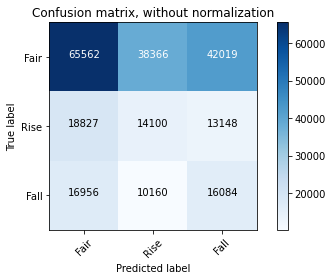

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred_50, labels=[0, 1, 2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=False, classes=['Fair', 'Rise', 'Fall'],
                      title='Confusion matrix, without normalization')

In [ ]:
accuracy_score(y_test, y_pred_50)

0.40704525937199754

In [ ]:
f1_score(y_test, y_pred_50, labels=[0, 1, 2], average=None)

array([0.53, 0.26, 0.28])

In [ ]:
f1_score(y_test, y_pred_50, labels=[0, 1, 2], average='macro')

0.35691010097804154

In [ ]:
f1_score(y_test, y_pred_50, labels=[0, 1, 2], average='weighted')

0.4314304186419195

Попробуем дообучить модель еще

In [ ]:
history = train(train_dataset, val_dataset, model=model_cnn, epochs=20, batch_size=256)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 0.9797909634968093


epoch:   5%|▌         | 1/20 [00:21<06:39, 21.02s/it]


Epoch 001 train_loss: 0.9798     val_loss 1.1499 train_acc 0.5064 val_acc 0.4043
loss 0.9658870678085979


epoch:  10%|█         | 2/20 [00:41<06:17, 21.00s/it]


Epoch 002 train_loss: 0.9659     val_loss 1.1519 train_acc 0.5151 val_acc 0.4168
loss 0.9459436723805238


epoch:  15%|█▌        | 3/20 [01:02<05:55, 20.94s/it]


Epoch 003 train_loss: 0.9459     val_loss 1.1809 train_acc 0.5280 val_acc 0.4176
loss 0.9237521024807356


epoch:  20%|██        | 4/20 [01:23<05:34, 20.92s/it]


Epoch 004 train_loss: 0.9238     val_loss 1.2004 train_acc 0.5422 val_acc 0.4233
loss 0.9007637274813343


epoch:  25%|██▌       | 5/20 [01:44<05:13, 20.91s/it]


Epoch 005 train_loss: 0.9008     val_loss 1.2225 train_acc 0.5566 val_acc 0.4240
loss 0.8813113313031672


epoch:  30%|███       | 6/20 [02:05<04:52, 20.88s/it]


Epoch 006 train_loss: 0.8813     val_loss 1.2201 train_acc 0.5689 val_acc 0.4301
loss 0.8625778487592661


epoch:  35%|███▌      | 7/20 [02:26<04:30, 20.83s/it]


Epoch 007 train_loss: 0.8626     val_loss 1.2238 train_acc 0.5791 val_acc 0.4350
loss 0.8448223018502408


epoch:  40%|████      | 8/20 [02:46<04:09, 20.80s/it]


Epoch 008 train_loss: 0.8448     val_loss 1.2412 train_acc 0.5914 val_acc 0.4355
loss 0.8282400042101258


epoch:  45%|████▌     | 9/20 [03:07<03:49, 20.82s/it]


Epoch 009 train_loss: 0.8282     val_loss 1.2895 train_acc 0.6008 val_acc 0.4324
loss 0.8119489200050101


epoch:  50%|█████     | 10/20 [03:28<03:28, 20.80s/it]


Epoch 010 train_loss: 0.8119     val_loss 1.3098 train_acc 0.6102 val_acc 0.4333
loss 0.7970238419271284


epoch:  55%|█████▌    | 11/20 [03:49<03:07, 20.81s/it]


Epoch 011 train_loss: 0.7970     val_loss 1.3206 train_acc 0.6188 val_acc 0.4311
loss 0.7830150924871037


epoch:  60%|██████    | 12/20 [04:10<02:46, 20.80s/it]


Epoch 012 train_loss: 0.7830     val_loss 1.3062 train_acc 0.6271 val_acc 0.4400
loss 0.9182182033449676


epoch:  65%|██████▌   | 13/20 [04:30<02:25, 20.72s/it]


Epoch 013 train_loss: 0.9182     val_loss 1.0441 train_acc 0.5540 val_acc 0.5078
loss 0.8641829971216867


epoch:  70%|███████   | 14/20 [04:51<02:03, 20.65s/it]


Epoch 014 train_loss: 0.8642     val_loss 1.0617 train_acc 0.5852 val_acc 0.5040
loss 0.8215906979504185


epoch:  75%|███████▌  | 15/20 [05:11<01:43, 20.65s/it]


Epoch 015 train_loss: 0.8216     val_loss 1.0786 train_acc 0.6101 val_acc 0.5071
loss 0.7865332587769456


epoch:  80%|████████  | 16/20 [05:32<01:22, 20.64s/it]


Epoch 016 train_loss: 0.7865     val_loss 1.0983 train_acc 0.6300 val_acc 0.5087
loss 0.7554643710778451


epoch:  85%|████████▌ | 17/20 [05:52<01:01, 20.64s/it]


Epoch 017 train_loss: 0.7555     val_loss 1.1219 train_acc 0.6474 val_acc 0.5097
loss 0.7268517991827889


epoch:  90%|█████████ | 18/20 [06:13<00:41, 20.59s/it]


Epoch 018 train_loss: 0.7269     val_loss 1.1514 train_acc 0.6630 val_acc 0.5102
loss 0.6998777578310951


epoch:  95%|█████████▌| 19/20 [06:33<00:20, 20.58s/it]


Epoch 019 train_loss: 0.6999     val_loss 1.1843 train_acc 0.6775 val_acc 0.5104
loss 0.6741553264751251


epoch: 100%|██████████| 20/20 [06:54<00:00, 20.73s/it]


Epoch 020 train_loss: 0.6742     val_loss 1.2216 train_acc 0.6911 val_acc 0.5114


In [ ]:
y_pred_70 = np.argmax(predict(model_cnn, test_loader), axis=1)

Confusion matrix, without normalization
[[65800 38321 41826]
 [19116 13870 13089]
 [16983 10095 16122]]


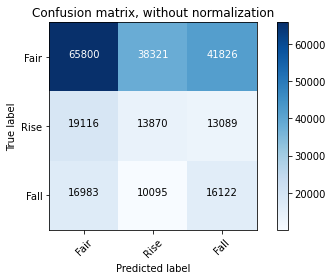

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred_70, labels=[0, 1, 2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=False, classes=['Fair', 'Rise', 'Fall'],
                      title='Confusion matrix, without normalization')

In [ ]:
f1_score(y_test, y_pred_70, labels=[0, 1, 2], average=None)

array([0.53, 0.26, 0.28])

In [ ]:
f1_score(y_test, y_pred_70, labels=[0, 1, 2], average='macro')

0.35640878395639614

In [ ]:
f1_score(y_test, y_pred_70, labels=[0, 1, 2], average='weighted')

0.43143346844239155

In [ ]:
accuracy_score(y_test, y_pred_70)

0.4072408193111189

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

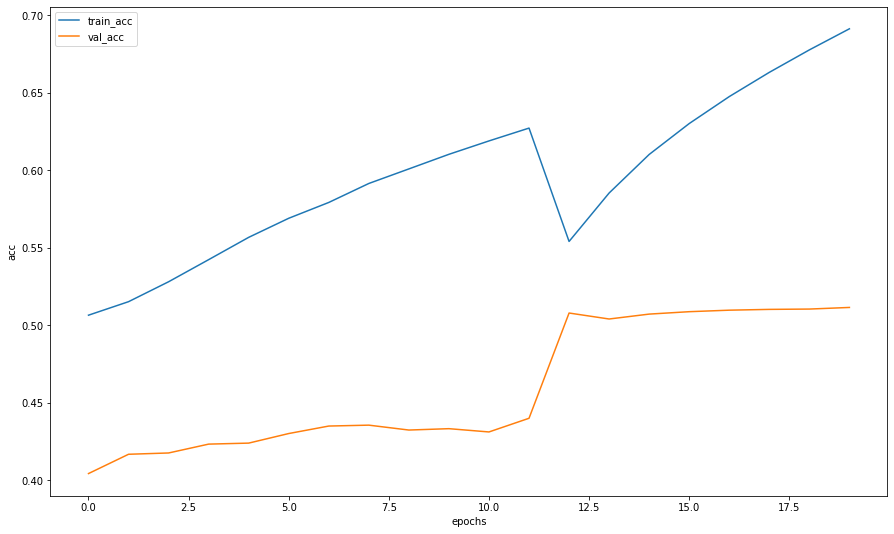

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

Лучше не стало

### Попробуем обучить модель на данных без применения андерсемплинга, чтобы она учитывала преобладание класса Fair

In [ ]:
X_train = torch.load('/content/drive/My Drive/x_train.pt')

In [ ]:
y_train = torch.load('/content/drive/My Drive/y_train.pt')

In [ ]:
gadf = GramianAngularField(image_size=20, method='difference')

In [ ]:
X_train_gadf_2 = gadf.fit_transform(X_train[:, :, 3])
X_val_gadf = gadf.fit_transform(X_val[:, :, 3])
X_test_gadf = gadf.fit_transform(X_test[:, :, 3])

In [ ]:
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train_gadf_2).reshape(-1, 1, 20, 20).float().cuda(), y_train.cuda())
val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val_gadf).reshape(-1, 1, 20, 20).float().cuda(), y_val.cuda())
test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test_gadf).reshape(-1, 1, 20, 20).float().cuda())

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=256, 
                                           shuffle=False)

In [ ]:
model_cnn_2 = ModelCnn(3).to(DEVICE)

In [ ]:
history = train(train_dataset, val_dataset, model=model_cnn_2, epochs=30, batch_size=256)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

loss 1.0394481815160341


epoch:   3%|▎         | 1/30 [00:28<13:53, 28.76s/it]


Epoch 001 train_loss: 1.0394     val_loss 1.0121 train_acc 0.5116 val_acc 0.5566
loss 1.0270223963263252


epoch:   7%|▋         | 2/30 [00:56<13:13, 28.34s/it]


Epoch 002 train_loss: 1.0270     val_loss 0.9823 train_acc 0.5186 val_acc 0.6371
loss 1.0246866721462418


epoch:  10%|█         | 3/30 [01:23<12:36, 28.01s/it]


Epoch 003 train_loss: 1.0247     val_loss 0.9901 train_acc 0.5188 val_acc 0.6029
loss 1.0239973883822084


epoch:  13%|█▎        | 4/30 [01:50<12:01, 27.76s/it]


Epoch 004 train_loss: 1.0240     val_loss 0.9817 train_acc 0.5187 val_acc 0.6107
loss 1.0233147527688229


epoch:  17%|█▋        | 5/30 [02:17<11:28, 27.52s/it]


Epoch 005 train_loss: 1.0233     val_loss 0.9800 train_acc 0.5189 val_acc 0.6052
loss 1.022780608801044


epoch:  20%|██        | 6/30 [02:44<10:56, 27.34s/it]


Epoch 006 train_loss: 1.0228     val_loss 0.9793 train_acc 0.5190 val_acc 0.6042
loss 1.0225567686093795


epoch:  23%|██▎       | 7/30 [03:11<10:26, 27.26s/it]


Epoch 007 train_loss: 1.0226     val_loss 0.9806 train_acc 0.5188 val_acc 0.6004
loss 1.0219806815852899


epoch:  27%|██▋       | 8/30 [03:38<09:58, 27.21s/it]


Epoch 008 train_loss: 1.0220     val_loss 0.9776 train_acc 0.5190 val_acc 0.5976
loss 1.021323278312778


epoch:  30%|███       | 9/30 [04:05<09:29, 27.11s/it]


Epoch 009 train_loss: 1.0213     val_loss 0.9765 train_acc 0.5192 val_acc 0.5979
loss 1.0203205272165836


epoch:  33%|███▎      | 10/30 [04:32<09:01, 27.06s/it]


Epoch 010 train_loss: 1.0203     val_loss 0.9770 train_acc 0.5194 val_acc 0.5959
loss 1.0192355711920846


epoch:  37%|███▋      | 11/30 [04:59<08:33, 27.02s/it]


Epoch 011 train_loss: 1.0192     val_loss 0.9745 train_acc 0.5196 val_acc 0.5963
loss 1.017710607365021


epoch:  40%|████      | 12/30 [05:26<08:06, 27.03s/it]


Epoch 012 train_loss: 1.0177     val_loss 0.9773 train_acc 0.5200 val_acc 0.5925
loss 1.0158642685067483


epoch:  43%|████▎     | 13/30 [05:53<07:40, 27.06s/it]


Epoch 013 train_loss: 1.0159     val_loss 0.9801 train_acc 0.5208 val_acc 0.5872
loss 1.013309506723551


epoch:  47%|████▋     | 14/30 [06:20<07:11, 26.96s/it]


Epoch 014 train_loss: 1.0133     val_loss 0.9805 train_acc 0.5214 val_acc 0.5841
loss 1.009682961488961


epoch:  50%|█████     | 15/30 [06:46<06:43, 26.88s/it]


Epoch 015 train_loss: 1.0097     val_loss 0.9812 train_acc 0.5230 val_acc 0.5794
loss 1.0044182663549641


epoch:  53%|█████▎    | 16/30 [07:13<06:15, 26.83s/it]


Epoch 016 train_loss: 1.0044     val_loss 0.9867 train_acc 0.5250 val_acc 0.5671
loss 0.9971620530974274


epoch:  57%|█████▋    | 17/30 [07:40<05:47, 26.75s/it]


Epoch 017 train_loss: 0.9972     val_loss 0.9903 train_acc 0.5283 val_acc 0.5543
loss 0.9872475072350465


epoch:  60%|██████    | 18/30 [08:06<05:20, 26.70s/it]


Epoch 018 train_loss: 0.9872     val_loss 0.9923 train_acc 0.5325 val_acc 0.5400
loss 0.9760182772721352


epoch:  63%|██████▎   | 19/30 [08:33<04:53, 26.72s/it]


Epoch 019 train_loss: 0.9760     val_loss 0.9957 train_acc 0.5376 val_acc 0.5287
loss 0.9632413710120681


epoch:  67%|██████▋   | 20/30 [09:00<04:27, 26.73s/it]


Epoch 020 train_loss: 0.9632     val_loss 1.0068 train_acc 0.5442 val_acc 0.5141
loss 0.9495682767564441


epoch:  70%|███████   | 21/30 [09:26<03:59, 26.62s/it]


Epoch 021 train_loss: 0.9496     val_loss 1.0162 train_acc 0.5510 val_acc 0.5033
loss 0.9358729606886953


epoch:  73%|███████▎  | 22/30 [09:53<03:32, 26.60s/it]


Epoch 022 train_loss: 0.9359     val_loss 1.0215 train_acc 0.5585 val_acc 0.5014
loss 0.9924656880499715


epoch:  77%|███████▋  | 23/30 [10:19<03:05, 26.54s/it]


Epoch 023 train_loss: 0.9925     val_loss 0.9534 train_acc 0.5287 val_acc 0.5800
loss 0.9745348477356091


epoch:  80%|████████  | 24/30 [10:46<02:39, 26.50s/it]


Epoch 024 train_loss: 0.9745     val_loss 0.9519 train_acc 0.5384 val_acc 0.5772
loss 0.9630039660650719


epoch:  83%|████████▎ | 25/30 [11:12<02:12, 26.53s/it]


Epoch 025 train_loss: 0.9630     val_loss 0.9524 train_acc 0.5444 val_acc 0.5734
loss 0.9528559854148645


epoch:  87%|████████▋ | 26/30 [11:39<01:45, 26.49s/it]


Epoch 026 train_loss: 0.9529     val_loss 0.9539 train_acc 0.5499 val_acc 0.5704
loss 0.9433424300540729


epoch:  90%|█████████ | 27/30 [12:05<01:19, 26.41s/it]


Epoch 027 train_loss: 0.9433     val_loss 0.9563 train_acc 0.5551 val_acc 0.5685
loss 0.9341368400152754


epoch:  93%|█████████▎| 28/30 [12:31<00:52, 26.43s/it]


Epoch 028 train_loss: 0.9341     val_loss 0.9591 train_acc 0.5601 val_acc 0.5654
loss 0.9251225112566891


epoch:  97%|█████████▋| 29/30 [12:58<00:26, 26.40s/it]


Epoch 029 train_loss: 0.9251     val_loss 0.9628 train_acc 0.5651 val_acc 0.5616
loss 0.9161598062411848


epoch: 100%|██████████| 30/30 [13:24<00:00, 26.81s/it]


Epoch 030 train_loss: 0.9162     val_loss 0.9666 train_acc 0.5706 val_acc 0.5601


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

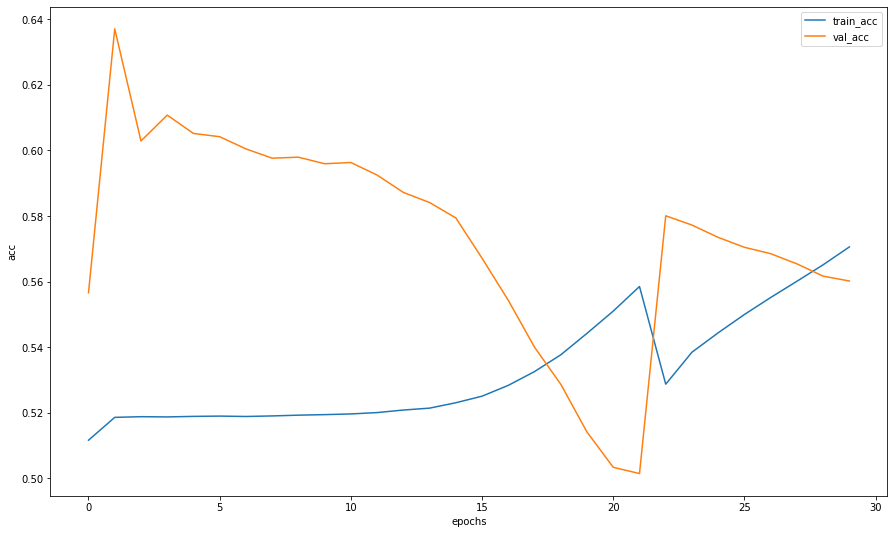

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

In [ ]:
y_pred_2 = np.argmax(predict(model_cnn_2, test_loader), axis=1)

Confusion matrix, without normalization
[[101049  14845  30053]
 [ 30721   5293  10061]
 [ 27705   3821  11674]]


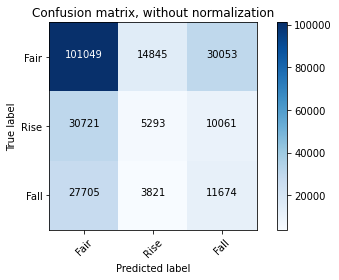

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred_2, labels=[0, 1, 2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=False, classes=['Fair', 'Rise', 'Fall'],
                      title='Confusion matrix, without normalization')

In [ ]:
f1_score(y_test, y_pred_2, labels=[0, 1, 2], average=None)

array([0.66, 0.15, 0.25])

In [ ]:
f1_score(y_test, y_pred_2, labels=[0, 1, 2], average='macro')

0.3528851608039831

In [ ]:
f1_score(y_test, y_pred_2, labels=[0, 1, 2], average='weighted')

0.48531287952203345

Теперь модель предсказывает класс 0 практически для всей выборки. Все так использование андерсемплинга было целесообразным

Все таки дообучим

In [ ]:
history = train(train_dataset, val_dataset, model=model_cnn_2, epochs=20, batch_size=256)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 0.9258134118197539


epoch:   5%|▌         | 1/20 [00:27<08:39, 27.32s/it]


Epoch 001 train_loss: 0.9258     val_loss 1.0143 train_acc 0.5644 val_acc 0.5089
loss 0.9080239779844981


epoch:  10%|█         | 2/20 [00:54<08:10, 27.23s/it]


Epoch 002 train_loss: 0.9080     val_loss 1.0314 train_acc 0.5745 val_acc 0.4999
loss 0.8922109567887444


epoch:  15%|█▌        | 3/20 [01:21<07:41, 27.14s/it]


Epoch 003 train_loss: 0.8922     val_loss 1.0381 train_acc 0.5822 val_acc 0.4942
loss 0.8764886804267034


epoch:  20%|██        | 4/20 [01:48<07:14, 27.15s/it]


Epoch 004 train_loss: 0.8765     val_loss 1.0500 train_acc 0.5906 val_acc 0.4935
loss 0.8622886161379416


epoch:  25%|██▌       | 5/20 [02:15<06:46, 27.11s/it]


Epoch 005 train_loss: 0.8623     val_loss 1.0561 train_acc 0.5976 val_acc 0.4955
loss 0.849433216138119


epoch:  30%|███       | 6/20 [02:42<06:19, 27.10s/it]


Epoch 006 train_loss: 0.8494     val_loss 1.0754 train_acc 0.6045 val_acc 0.4883
loss 0.8365577128815498


epoch:  35%|███▌      | 7/20 [03:09<05:52, 27.11s/it]


Epoch 007 train_loss: 0.8366     val_loss 1.0916 train_acc 0.6111 val_acc 0.4801
loss 0.8251956620488452


epoch:  40%|████      | 8/20 [03:36<05:25, 27.10s/it]


Epoch 008 train_loss: 0.8252     val_loss 1.0967 train_acc 0.6170 val_acc 0.4873
loss 0.8143381405959317


epoch:  45%|████▌     | 9/20 [04:03<04:58, 27.11s/it]


Epoch 009 train_loss: 0.8143     val_loss 1.1003 train_acc 0.6223 val_acc 0.4867
loss 0.8057276157309449


epoch:  50%|█████     | 10/20 [04:31<04:31, 27.13s/it]


Epoch 010 train_loss: 0.8057     val_loss 1.1272 train_acc 0.6264 val_acc 0.4775
loss 0.7961218311569824


epoch:  55%|█████▌    | 11/20 [04:58<04:04, 27.12s/it]


Epoch 011 train_loss: 0.7961     val_loss 1.1235 train_acc 0.6310 val_acc 0.4825
loss 0.7880609483959014


epoch:  60%|██████    | 12/20 [05:25<03:37, 27.16s/it]


Epoch 012 train_loss: 0.7881     val_loss 1.1297 train_acc 0.6351 val_acc 0.4801
loss 0.961706955613143


epoch:  65%|██████▌   | 13/20 [05:52<03:09, 27.11s/it]


Epoch 013 train_loss: 0.9617     val_loss 0.9737 train_acc 0.5460 val_acc 0.5606
loss 0.9186916872224726


epoch:  70%|███████   | 14/20 [06:18<02:41, 26.91s/it]


Epoch 014 train_loss: 0.9187     val_loss 0.9728 train_acc 0.5679 val_acc 0.5590
loss 0.893552417327912


epoch:  75%|███████▌  | 15/20 [06:44<02:12, 26.56s/it]


Epoch 015 train_loss: 0.8936     val_loss 0.9775 train_acc 0.5817 val_acc 0.5566
loss 0.8728916785722961


epoch:  80%|████████  | 16/20 [07:10<01:45, 26.32s/it]


Epoch 016 train_loss: 0.8729     val_loss 0.9840 train_acc 0.5933 val_acc 0.5551
loss 0.854668622659779


epoch:  85%|████████▌ | 17/20 [07:36<01:18, 26.17s/it]


Epoch 017 train_loss: 0.8547     val_loss 0.9925 train_acc 0.6031 val_acc 0.5530
loss 0.8378075844103989


epoch:  90%|█████████ | 18/20 [08:01<00:52, 26.01s/it]


Epoch 018 train_loss: 0.8378     val_loss 1.0024 train_acc 0.6126 val_acc 0.5522
loss 0.8219582989153146


epoch:  95%|█████████▌| 19/20 [08:27<00:25, 25.88s/it]


Epoch 019 train_loss: 0.8220     val_loss 1.0139 train_acc 0.6213 val_acc 0.5511
loss 0.8067938886517358


epoch: 100%|██████████| 20/20 [08:52<00:00, 26.65s/it]


Epoch 020 train_loss: 0.8068     val_loss 1.0264 train_acc 0.6295 val_acc 0.5491


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

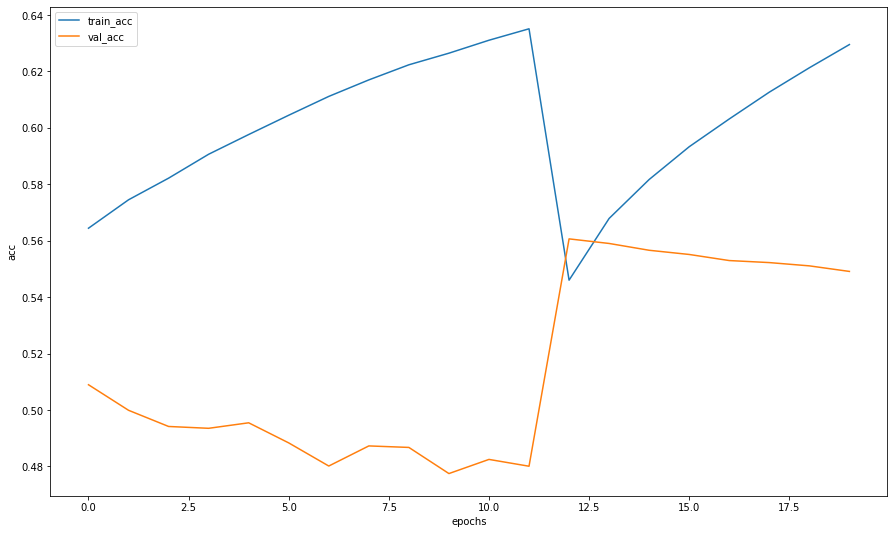

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

In [ ]:
y_pred_2 = np.argmax(predict(model_cnn_2, test_loader), axis=1)

Confusion matrix, without normalization
[[90686 21744 33517]
 [27202  7966 10907]
 [24497  5829 12874]]


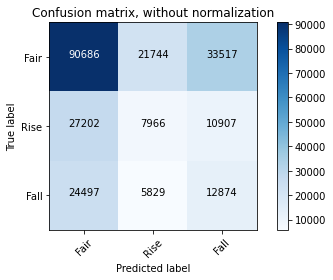

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred_2, labels=[0, 1, 2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=False, classes=['Fair', 'Rise', 'Fall'],
                      title='Confusion matrix, without normalization')

In [ ]:
f1_score(y_test, y_pred_2, labels=[0, 1, 2], average=None)

array([0.63, 0.2 , 0.26])

In [ ]:
f1_score(y_test, y_pred_2, labels=[0, 1, 2], average='macro')

0.3601514854720578

In [ ]:
f1_score(y_test, y_pred_2, labels=[0, 1, 2], average='weighted')

0.4755877852497241

### Попробуем изменить разделение данных на классы

In [ ]:
%%time
X_train_5, y_train_5 = fast_data_transformer(scaled_train_data, threshold=0.05)

CPU times: user 4min 28s, sys: 7.27 s, total: 4min 35s
Wall time: 4min 35s


In [ ]:
torch.save(X_train_5, '/content/drive/MyDrive/x_train_5.pt')
torch.save(y_train_5, '/content/drive/MyDrive/y_train_5.pt')

In [ ]:
X_test_5, y_test_5 = fast_data_transformer(scaled_test_data, threshold=0.05)

In [ ]:
torch.save(X_test_5, '/content/drive/MyDrive/x_test_5.pt')
torch.save(y_test_5, '/content/drive/MyDrive/y_test_5.pt')

In [ ]:
X_val_5, y_val_5 = fast_data_transformer(scaled_val_data, threshold=0.05)

In [ ]:
torch.save(X_val_5, '/content/drive/MyDrive/x_val_5.pt')
torch.save(y_val_5, '/content/drive/MyDrive/y_val_5.pt')

In [ ]:
y_val_5

tensor([0, 0, 0,  ..., 0, 0, 0])

In [ ]:
X_train_5 = torch.load('/content/drive/My Drive/x_train_5.pt')

In [ ]:
y_train_5 = torch.load('/content/drive/My Drive/y_train_5.pt')

In [ ]:
X_test_5 = torch.load('/content/drive/My Drive/x_test_5.pt')

In [ ]:
y_test_5 = torch.load('/content/drive/My Drive/y_test_5.pt')

In [ ]:
X_val_5 = torch.load('/content/drive/My Drive/x_val_5.pt')

In [ ]:
y_val_5 = torch.load('/content/drive/My Drive/y_val_5.pt')

Посмотрим на распределение ответов на обучающей выборке 

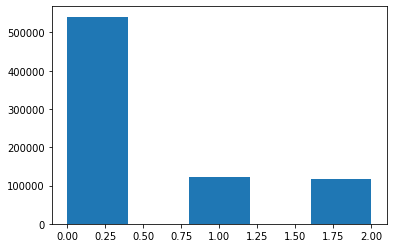

In [ ]:
_ = plt.hist(y_train_5, bins=5)

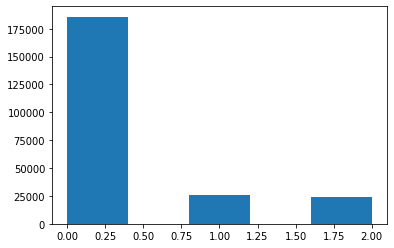

In [ ]:
_ = plt.hist(y_test_5, bins=5)

### Андерсемплинг

In [ ]:
np.random.seed(42)

In [ ]:
def undersample(X, y):
  indices = np.where(y == 0)[0]
  indices_to_drop = np.random.choice(indices, size=650000)
  return X[np.array(list(set(np.arange(X.shape[0])) - set(indices_to_drop)))], y[np.array(list(set(np.arange(X.shape[0])) - set(indices_to_drop)))]

In [ ]:
X_train_undersampled_5, y_train_undersampled_5 = undersample(X_train_5, y_train_5)

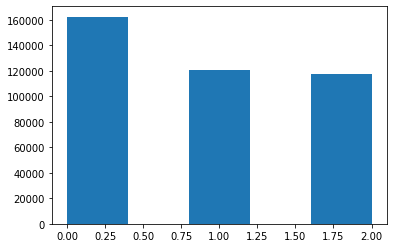

In [ ]:
_ = plt.hist(y_train_undersampled_5, bins=5)

In [ ]:
gadf = GramianAngularField(image_size=20, method='difference')

In [ ]:
X_train_gadf_5 = gadf.fit_transform(X_train_undersampled_5[:, :, 3])
X_val_gadf_5 = gadf.fit_transform(X_val_5[:, :, 3])
X_test_gadf_5 = gadf.fit_transform(X_test_5[:, :, 3])

In [ ]:
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train_gadf_5).reshape(-1, 1, 20, 20).float().cuda(), y_train_undersampled_5.cuda())
val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val_gadf_5).reshape(-1, 1, 20, 20).float().cuda(), y_val_5.cuda())
test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test_gadf_5).reshape(-1, 1, 20, 20).float().cuda())

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=256, 
                                           shuffle=False)

In [ ]:
model_cnn_5 = ModelCnn(3).to(DEVICE)

In [ ]:
history = train(train_dataset, val_dataset, model=model_cnn_5, epochs=30, batch_size=256)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

loss 1.102387363975612


epoch:   3%|▎         | 1/30 [00:14<07:09, 14.82s/it]


Epoch 001 train_loss: 1.1024     val_loss 1.1181 train_acc 0.3982 val_acc 0.3750
loss 1.088340291247173


epoch:   7%|▋         | 2/30 [00:29<06:54, 14.80s/it]


Epoch 002 train_loss: 1.0883     val_loss 1.0523 train_acc 0.4056 val_acc 0.8152
loss 1.0864859825464581


epoch:  10%|█         | 3/30 [00:44<06:38, 14.76s/it]


Epoch 003 train_loss: 1.0865     val_loss 1.1368 train_acc 0.4072 val_acc 0.4673
loss 1.0859624244104058


epoch:  13%|█▎        | 4/30 [00:58<06:22, 14.70s/it]


Epoch 004 train_loss: 1.0860     val_loss 1.1580 train_acc 0.4087 val_acc 0.3939
loss 1.0853700980805703


epoch:  17%|█▋        | 5/30 [01:13<06:06, 14.67s/it]


Epoch 005 train_loss: 1.0854     val_loss 1.1252 train_acc 0.4087 val_acc 0.4842
loss 1.0848829268238562


epoch:  20%|██        | 6/30 [01:28<05:54, 14.79s/it]


Epoch 006 train_loss: 1.0849     val_loss 1.0913 train_acc 0.4103 val_acc 0.5266
loss 1.084399469019743


epoch:  23%|██▎       | 7/30 [01:43<05:44, 14.97s/it]


Epoch 007 train_loss: 1.0844     val_loss 1.1122 train_acc 0.4109 val_acc 0.4708
loss 1.08373262961398


epoch:  27%|██▋       | 8/30 [01:58<05:29, 14.96s/it]


Epoch 008 train_loss: 1.0837     val_loss 1.0952 train_acc 0.4122 val_acc 0.5046
loss 1.0834796354229077


epoch:  30%|███       | 9/30 [02:13<05:09, 14.75s/it]


Epoch 009 train_loss: 1.0835     val_loss 1.0861 train_acc 0.4126 val_acc 0.5048
loss 1.0822053362535715


epoch:  33%|███▎      | 10/30 [02:27<04:54, 14.73s/it]


Epoch 010 train_loss: 1.0822     val_loss 1.0966 train_acc 0.4149 val_acc 0.5100
loss 1.080512157914295


epoch:  37%|███▋      | 11/30 [02:42<04:38, 14.68s/it]


Epoch 011 train_loss: 1.0805     val_loss 1.0925 train_acc 0.4168 val_acc 0.5356
loss 1.0783791589695777


epoch:  40%|████      | 12/30 [02:56<04:21, 14.51s/it]


Epoch 012 train_loss: 1.0784     val_loss 1.0939 train_acc 0.4199 val_acc 0.5358
loss 1.0747411722030182


epoch:  43%|████▎     | 13/30 [03:10<04:04, 14.36s/it]


Epoch 013 train_loss: 1.0747     val_loss 1.0975 train_acc 0.4246 val_acc 0.4874
loss 1.0735682622131915


epoch:  47%|████▋     | 14/30 [03:24<03:48, 14.28s/it]


Epoch 014 train_loss: 1.0736     val_loss 1.0053 train_acc 0.4235 val_acc 0.6234
loss 1.0683430876474873


epoch:  50%|█████     | 15/30 [03:38<03:34, 14.29s/it]


Epoch 015 train_loss: 1.0683     val_loss 1.0048 train_acc 0.4308 val_acc 0.5961
loss 1.064846756818622


epoch:  53%|█████▎    | 16/30 [03:52<03:19, 14.22s/it]


Epoch 016 train_loss: 1.0648     val_loss 1.0068 train_acc 0.4348 val_acc 0.5711
loss 1.06128338502845


epoch:  57%|█████▋    | 17/30 [04:07<03:07, 14.46s/it]


Epoch 017 train_loss: 1.0613     val_loss 1.0097 train_acc 0.4382 val_acc 0.5475
loss 1.0573818329536504


epoch:  60%|██████    | 18/30 [04:22<02:53, 14.46s/it]


Epoch 018 train_loss: 1.0574     val_loss 1.0119 train_acc 0.4422 val_acc 0.5252
loss 1.0529244061560823


epoch:  63%|██████▎   | 19/30 [04:36<02:37, 14.35s/it]


Epoch 019 train_loss: 1.0529     val_loss 1.0151 train_acc 0.4465 val_acc 0.5085
loss 1.0477111761889297


epoch:  67%|██████▋   | 20/30 [04:50<02:23, 14.37s/it]


Epoch 020 train_loss: 1.0477     val_loss 1.0176 train_acc 0.4514 val_acc 0.4949
loss 1.0416526918304532


epoch:  70%|███████   | 21/30 [05:04<02:07, 14.21s/it]


Epoch 021 train_loss: 1.0417     val_loss 1.0199 train_acc 0.4568 val_acc 0.4827
loss 1.0345334282721927


epoch:  73%|███████▎  | 22/30 [05:19<01:54, 14.35s/it]


Epoch 022 train_loss: 1.0345     val_loss 1.0223 train_acc 0.4631 val_acc 0.4744
loss 1.0261780184652105


epoch:  77%|███████▋  | 23/30 [05:33<01:39, 14.28s/it]


Epoch 023 train_loss: 1.0262     val_loss 1.0242 train_acc 0.4705 val_acc 0.4668
loss 1.0165888969566508


epoch:  80%|████████  | 24/30 [05:47<01:25, 14.28s/it]


Epoch 024 train_loss: 1.0166     val_loss 1.0272 train_acc 0.4787 val_acc 0.4588
loss 1.0057917824151577


epoch:  83%|████████▎ | 25/30 [06:01<01:10, 14.16s/it]


Epoch 025 train_loss: 1.0058     val_loss 1.0305 train_acc 0.4873 val_acc 0.4544
loss 0.9939137716107047


epoch:  87%|████████▋ | 26/30 [06:16<00:56, 14.23s/it]


Epoch 026 train_loss: 0.9939     val_loss 1.0344 train_acc 0.4963 val_acc 0.4517
loss 1.0023689411183536


epoch:  90%|█████████ | 27/30 [06:30<00:42, 14.20s/it]


Epoch 027 train_loss: 1.0024     val_loss 0.9779 train_acc 0.4880 val_acc 0.5183
loss 0.9975464575454929


epoch:  93%|█████████▎| 28/30 [06:44<00:28, 14.28s/it]


Epoch 028 train_loss: 0.9975     val_loss 0.9729 train_acc 0.4926 val_acc 0.5248
loss 0.9952977661387317


epoch:  97%|█████████▋| 29/30 [06:58<00:14, 14.26s/it]


Epoch 029 train_loss: 0.9953     val_loss 0.9720 train_acc 0.4943 val_acc 0.5262
loss 0.9933243883256544


epoch: 100%|██████████| 30/30 [07:12<00:00, 14.43s/it]


Epoch 030 train_loss: 0.9933     val_loss 0.9714 train_acc 0.4958 val_acc 0.5263


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

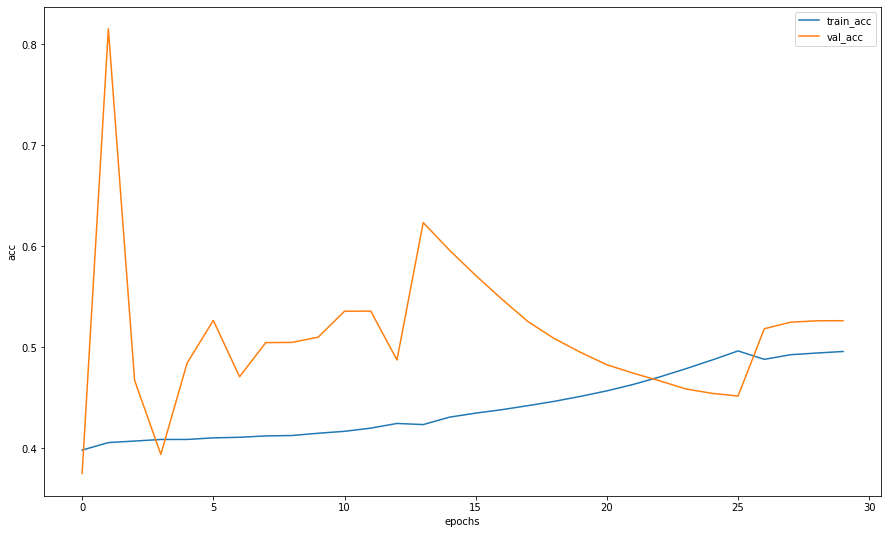

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

In [ ]:
y_pred_5 = np.argmax(predict(model_cnn_5, test_loader), axis=1)

Confusion matrix, without normalization
[[101136  45477  39100]
 [ 13131   6894   5419]
 [ 11258   5634   7173]]


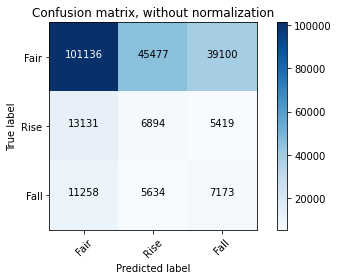

In [ ]:
cnf_matrix = confusion_matrix(y_test_5, y_pred_5, labels=[0, 1, 2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=False, classes=['Fair', 'Rise', 'Fall'],
                      title='Confusion matrix, without normalization')

In [ ]:
f1_score(y_test_5, y_pred_5, labels=[0, 1, 2], average=None)

array([0.65, 0.17, 0.19])

In [ ]:
f1_score(y_test_5, y_pred_5, labels=[0, 1, 2], average='macro')

0.33483008009948784

In [ ]:
f1_score(y_test_5, y_pred_5, labels=[0, 1, 2], average='weighted')

0.5503529507092828

In [ ]:
history = train(train_dataset, val_dataset, model=model_cnn_5, epochs=20, batch_size=256)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 1.0402128971435458


epoch:   5%|▌         | 1/20 [00:14<04:31, 14.31s/it]


Epoch 001 train_loss: 1.0402     val_loss 1.1459 train_acc 0.4574 val_acc 0.3182
loss 1.028412596281244


epoch:  10%|█         | 2/20 [00:28<04:18, 14.38s/it]


Epoch 002 train_loss: 1.0284     val_loss 1.1658 train_acc 0.4679 val_acc 0.3171
loss 1.0075274932061828


epoch:  15%|█▌        | 3/20 [00:42<04:02, 14.24s/it]


Epoch 003 train_loss: 1.0075     val_loss 1.2004 train_acc 0.4844 val_acc 0.3219
loss 0.9812721109395671


epoch:  20%|██        | 4/20 [00:57<03:47, 14.24s/it]


Epoch 004 train_loss: 0.9813     val_loss 1.2090 train_acc 0.5035 val_acc 0.3500
loss 0.9513672040752903


epoch:  25%|██▌       | 5/20 [01:11<03:35, 14.35s/it]


Epoch 005 train_loss: 0.9514     val_loss 1.2512 train_acc 0.5233 val_acc 0.3463
loss 0.9223903353175107


epoch:  30%|███       | 6/20 [01:25<03:20, 14.35s/it]


Epoch 006 train_loss: 0.9224     val_loss 1.2876 train_acc 0.5413 val_acc 0.3763
loss 0.893108611374443


epoch:  35%|███▌      | 7/20 [01:39<03:03, 14.10s/it]


Epoch 007 train_loss: 0.8931     val_loss 1.3188 train_acc 0.5592 val_acc 0.3731
loss 0.8648556284149278


epoch:  40%|████      | 8/20 [01:54<02:50, 14.24s/it]


Epoch 008 train_loss: 0.8649     val_loss 1.3828 train_acc 0.5762 val_acc 0.3683
loss 0.8376008625744261


epoch:  45%|████▌     | 9/20 [02:08<02:36, 14.19s/it]


Epoch 009 train_loss: 0.8376     val_loss 1.4365 train_acc 0.5923 val_acc 0.3634
loss 0.8119764887918185


epoch:  50%|█████     | 10/20 [02:23<02:24, 14.40s/it]


Epoch 010 train_loss: 0.8120     val_loss 1.4966 train_acc 0.6072 val_acc 0.3603
loss 0.7882248988668656


epoch:  55%|█████▌    | 11/20 [02:37<02:09, 14.44s/it]


Epoch 011 train_loss: 0.7882     val_loss 1.5154 train_acc 0.6211 val_acc 0.3659
loss 0.7639735032726405


epoch:  60%|██████    | 12/20 [02:52<01:56, 14.52s/it]


Epoch 012 train_loss: 0.7640     val_loss 1.4919 train_acc 0.6356 val_acc 0.3851
loss 0.8142153986060287


epoch:  65%|██████▌   | 13/20 [03:06<01:40, 14.41s/it]


Epoch 013 train_loss: 0.8142     val_loss 1.1118 train_acc 0.6132 val_acc 0.4998
loss 0.7402903018424505


epoch:  70%|███████   | 14/20 [03:21<01:26, 14.49s/it]


Epoch 014 train_loss: 0.7403     val_loss 1.1439 train_acc 0.6513 val_acc 0.4983
loss 0.6917517988747658


epoch:  75%|███████▌  | 15/20 [03:34<01:11, 14.24s/it]


Epoch 015 train_loss: 0.6918     val_loss 1.1851 train_acc 0.6776 val_acc 0.5005
loss 0.6506621055699913


epoch:  80%|████████  | 16/20 [03:48<00:56, 14.06s/it]


Epoch 016 train_loss: 0.6507     val_loss 1.2349 train_acc 0.6996 val_acc 0.5016
loss 0.6135698061393968


epoch:  85%|████████▌ | 17/20 [04:02<00:42, 14.11s/it]


Epoch 017 train_loss: 0.6136     val_loss 1.2927 train_acc 0.7191 val_acc 0.5042
loss 0.579385122896931


epoch:  90%|█████████ | 18/20 [04:17<00:28, 14.22s/it]


Epoch 018 train_loss: 0.5794     val_loss 1.3587 train_acc 0.7365 val_acc 0.5079
loss 0.5471215733765142


epoch:  95%|█████████▌| 19/20 [04:31<00:14, 14.17s/it]


Epoch 019 train_loss: 0.5471     val_loss 1.4381 train_acc 0.7525 val_acc 0.5094
loss 0.5164289407088363


epoch: 100%|██████████| 20/20 [04:44<00:00, 14.24s/it]


Epoch 020 train_loss: 0.5164     val_loss 1.5297 train_acc 0.7676 val_acc 0.5109


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

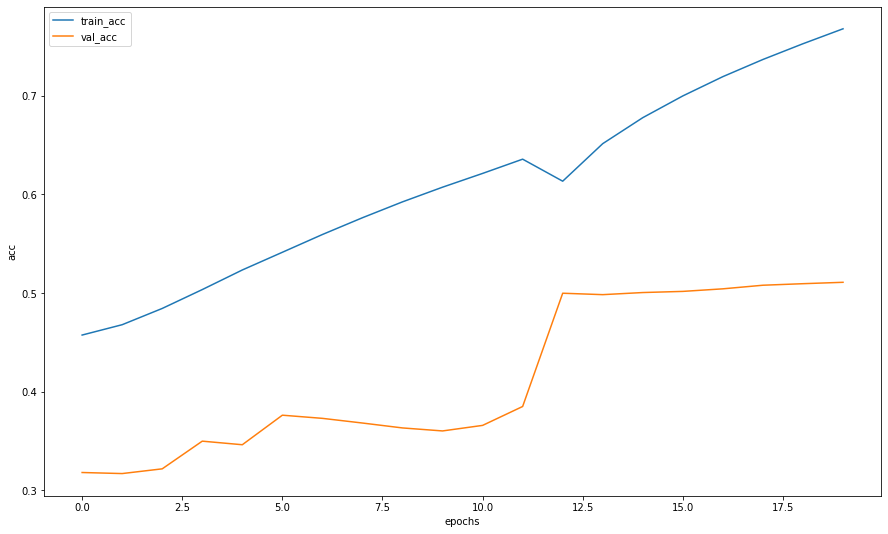

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

In [ ]:
y_pred_5 = np.argmax(predict(model_cnn_5, test_loader), axis=1)

Confusion matrix, without normalization
[[81053 52751 51909]
 [ 9831  8655  6958]
 [ 8746  5892  9427]]


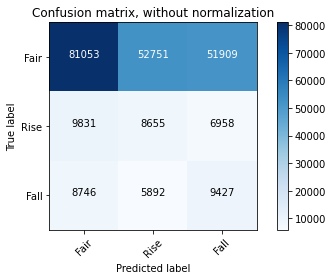

In [ ]:
cnf_matrix = confusion_matrix(y_test_5, y_pred_5, labels=[0, 1, 2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=False, classes=['Fair', 'Rise', 'Fall'],
                      title='Confusion matrix, without normalization')

In [ ]:
accuracy_score(y_test_5, y_pred_5)

0.42145292532161105

In [ ]:
f1_score(y_test_5, y_pred_5, labels=[0, 1, 2], average=None)

array([0.57, 0.19, 0.2 ])

In [ ]:
f1_score(y_test_5, y_pred_5, labels=[0, 1, 2], average='macro')

0.31963142817059914

In [ ]:
f1_score(y_test_5, y_pred_5, labels=[0, 1, 2], average='weighted')

0.48960939990664304

In [ ]:
torch.save(model_cnn_5.state_dict(), '/content/drive/MyDrive/GADF_CNN_5.pth')

### Закодируем с помощью GADF все 5 признаков

In [ ]:
train_dataset = torch.utils.data.TensorDataset(X_train_undersampled.float(), y_train_undersampled)
val_dataset = torch.utils.data.TensorDataset(X_val.float(), y_val)
test_dataset = torch.utils.data.TensorDataset(X_test.float())

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=256, 
                                           shuffle=False)

In [ ]:
DEVICE = torch.device("cuda")
use_gpu = True

In [ ]:
import torch.nn.functional as F  # Functional
class ModelCnn5ch(nn.Module):
  
    def __init__(self, n_classes):
        
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=5, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=2, stride=1)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            #nn.MaxPool2d(kernel_size=3, stride=1)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(2 * 2 * 256, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        
        self.fc3 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU()
        )
        
        self.fc4 = nn.Sequential(
            nn.Linear(1024, n_classes)
        )  

  
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        #x = self.conv4(x)
        #x = self.conv5(x)
        

        #x = F.interpolate(x, size=(2, 2), mode='bilinear')  # resize to the size expected by the linear unit
        x = x.view(x.size(0), 2 * 2 * 256)
    
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        x = self.fc4(x)
        
        return x

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    gadf = GramianAngularField(image_size=20, method='difference')
    
    for inputs, labels in train_loader:
        inputs = np.stack((gadf.fit_transform(inputs[:, :, 0]), gadf.fit_transform(inputs[:, :, 1]), gadf.fit_transform(inputs[:, :, 2]), gadf.fit_transform(inputs[:, :, 3]), gadf.fit_transform(inputs[:, :, 4])), axis=1)
        inputs = torch.tensor(inputs).float().to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    gadf = GramianAngularField(image_size=20, method='difference')
    
    for inputs, labels in val_loader:
        inputs = np.stack((gadf.fit_transform(inputs[:, :, 0]), gadf.fit_transform(inputs[:, :, 1]), gadf.fit_transform(inputs[:, :, 2]), gadf.fit_transform(inputs[:, :, 3]), gadf.fit_transform(inputs[:, :, 4])), axis=1)
        inputs = torch.tensor(inputs).float().to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(dataset=train_files, 
                                           batch_size=batch_size, 
                                           shuffle=False)
    val_loader = DataLoader(dataset=val_files, 
                                           batch_size=batch_size, 
                                           shuffle=False)
    

    #dataset_sizes = {'train': len(new_train_dataset), 'val':len(val_dataset) }

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            scheduler.step(val_loss)
            
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
        gadf = GramianAngularField(image_size=20, method='difference')

        for inputs in test_loader:
          inputs = inputs[0]
          #print(inputs.shape)
          inputs = np.stack((gadf.fit_transform(inputs[:, :, 0]), gadf.fit_transform(inputs[:, :, 1]), gadf.fit_transform(inputs[:, :, 2]), gadf.fit_transform(inputs[:, :, 3]), gadf.fit_transform(inputs[:, :, 4])), axis=1)
          inputs = torch.tensor(inputs).float().to(DEVICE)
          model.eval()
          outputs = model(inputs).cpu()
          logits.append(outputs)
          
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
model_cnn_all = ModelCnn5ch(3).to(DEVICE)

In [ ]:
history = train(train_dataset, val_dataset, model=model_cnn_all, epochs=30, batch_size=256)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

loss 1.1006574333446029


epoch:   3%|▎         | 1/30 [00:48<23:14, 48.09s/it]


Epoch 001 train_loss: 1.1007     val_loss 1.1390 train_acc 0.3939 val_acc 0.3607
loss 1.089781828521199


epoch:   7%|▋         | 2/30 [01:35<22:19, 47.83s/it]


Epoch 002 train_loss: 1.0898     val_loss 1.1011 train_acc 0.3979 val_acc 0.4197
loss 1.0873455066377218


epoch:  10%|█         | 3/30 [02:22<21:25, 47.62s/it]


Epoch 003 train_loss: 1.0873     val_loss 1.0963 train_acc 0.4028 val_acc 0.4453
loss 1.0840122810682307


epoch:  13%|█▎        | 4/30 [03:09<20:32, 47.39s/it]


Epoch 004 train_loss: 1.0840     val_loss 1.0869 train_acc 0.4095 val_acc 0.4127
loss 1.081340116086951


epoch:  17%|█▋        | 5/30 [03:55<19:34, 46.96s/it]


Epoch 005 train_loss: 1.0813     val_loss 1.0582 train_acc 0.4151 val_acc 0.5007
loss 1.0787539293178805


epoch:  20%|██        | 6/30 [04:40<18:38, 46.59s/it]


Epoch 006 train_loss: 1.0788     val_loss 1.0883 train_acc 0.4197 val_acc 0.4097
loss 1.0761457656151585


epoch:  23%|██▎       | 7/30 [05:26<17:46, 46.39s/it]


Epoch 007 train_loss: 1.0761     val_loss 1.0798 train_acc 0.4242 val_acc 0.4271
loss 1.0720702736042425


epoch:  27%|██▋       | 8/30 [06:13<17:04, 46.56s/it]


Epoch 008 train_loss: 1.0721     val_loss 1.0752 train_acc 0.4305 val_acc 0.4265
loss 1.0658029095491488


epoch:  30%|███       | 9/30 [07:01<16:25, 46.92s/it]


Epoch 009 train_loss: 1.0658     val_loss 1.0764 train_acc 0.4401 val_acc 0.4130
loss 1.05687632083388


epoch:  33%|███▎      | 10/30 [07:48<15:37, 46.88s/it]


Epoch 010 train_loss: 1.0569     val_loss 1.0762 train_acc 0.4511 val_acc 0.4179
loss 1.04286994711091


epoch:  37%|███▋      | 11/30 [08:34<14:44, 46.53s/it]


Epoch 011 train_loss: 1.0429     val_loss 1.0997 train_acc 0.4667 val_acc 0.3898
loss 1.023420339766818


epoch:  40%|████      | 12/30 [09:19<13:49, 46.07s/it]


Epoch 012 train_loss: 1.0234     val_loss 1.1036 train_acc 0.4842 val_acc 0.3982
loss 0.9979410028776412


epoch:  43%|████▎     | 13/30 [10:04<12:59, 45.83s/it]


Epoch 013 train_loss: 0.9979     val_loss 1.1191 train_acc 0.5040 val_acc 0.3962
loss 0.9682574828247332


epoch:  47%|████▋     | 14/30 [10:49<12:07, 45.47s/it]


Epoch 014 train_loss: 0.9683     val_loss 1.1182 train_acc 0.5249 val_acc 0.4122
loss 0.9347155573650429


epoch:  50%|█████     | 15/30 [11:33<11:17, 45.16s/it]


Epoch 015 train_loss: 0.9347     val_loss 1.1636 train_acc 0.5472 val_acc 0.3875
loss 0.8995918415118904


epoch:  53%|█████▎    | 16/30 [12:17<10:28, 44.92s/it]


Epoch 016 train_loss: 0.8996     val_loss 1.2196 train_acc 0.5689 val_acc 0.3813
loss 1.0067481902717694


epoch:  57%|█████▋    | 17/30 [13:02<09:41, 44.74s/it]


Epoch 017 train_loss: 1.0067     val_loss 1.0569 train_acc 0.4949 val_acc 0.4882
loss 0.9614859303262081


epoch:  60%|██████    | 18/30 [13:45<08:53, 44.47s/it]


Epoch 018 train_loss: 0.9615     val_loss 1.0781 train_acc 0.5292 val_acc 0.4846
loss 0.9241430117862337


epoch:  63%|██████▎   | 19/30 [14:29<08:06, 44.22s/it]


Epoch 019 train_loss: 0.9241     val_loss 1.1053 train_acc 0.5564 val_acc 0.4844
loss 0.8877632766850794


epoch:  67%|██████▋   | 20/30 [15:13<07:20, 44.09s/it]


Epoch 020 train_loss: 0.8878     val_loss 1.1385 train_acc 0.5813 val_acc 0.4858
loss 0.8508222634197818


epoch:  70%|███████   | 21/30 [15:57<06:36, 44.08s/it]


Epoch 021 train_loss: 0.8508     val_loss 1.1787 train_acc 0.6057 val_acc 0.4881
loss 0.8128841097387655


epoch:  73%|███████▎  | 22/30 [16:41<05:51, 43.97s/it]


Epoch 022 train_loss: 0.8129     val_loss 1.2236 train_acc 0.6289 val_acc 0.4900
loss 0.7736806014531773


epoch:  77%|███████▋  | 23/30 [17:24<05:06, 43.81s/it]


Epoch 023 train_loss: 0.7737     val_loss 1.2779 train_acc 0.6519 val_acc 0.4936
loss 0.7330529968492541


epoch:  80%|████████  | 24/30 [18:08<04:22, 43.78s/it]


Epoch 024 train_loss: 0.7331     val_loss 1.3434 train_acc 0.6747 val_acc 0.4984
loss 0.6909480550224462


epoch:  83%|████████▎ | 25/30 [18:51<03:38, 43.70s/it]


Epoch 025 train_loss: 0.6909     val_loss 1.4310 train_acc 0.6975 val_acc 0.5021
loss 0.647573595313187


epoch:  87%|████████▋ | 26/30 [19:35<02:54, 43.65s/it]


Epoch 026 train_loss: 0.6476     val_loss 1.5402 train_acc 0.7196 val_acc 0.5048
loss 0.6033834107565061


epoch:  90%|█████████ | 27/30 [20:18<02:10, 43.62s/it]


Epoch 027 train_loss: 0.6034     val_loss 1.6790 train_acc 0.7416 val_acc 0.5083
loss 0.5585328949984046


epoch:  93%|█████████▎| 28/30 [21:02<01:27, 43.70s/it]


Epoch 028 train_loss: 0.5585     val_loss 1.8510 train_acc 0.7633 val_acc 0.5096
loss 0.9393299305098214


epoch:  97%|█████████▋| 29/30 [21:46<00:43, 43.70s/it]


Epoch 029 train_loss: 0.9393     val_loss 0.9982 train_acc 0.5991 val_acc 0.5804
loss 0.8378498995439502


epoch: 100%|██████████| 30/30 [22:29<00:00, 44.99s/it]


Epoch 030 train_loss: 0.8378     val_loss 0.9688 train_acc 0.6221 val_acc 0.5858


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

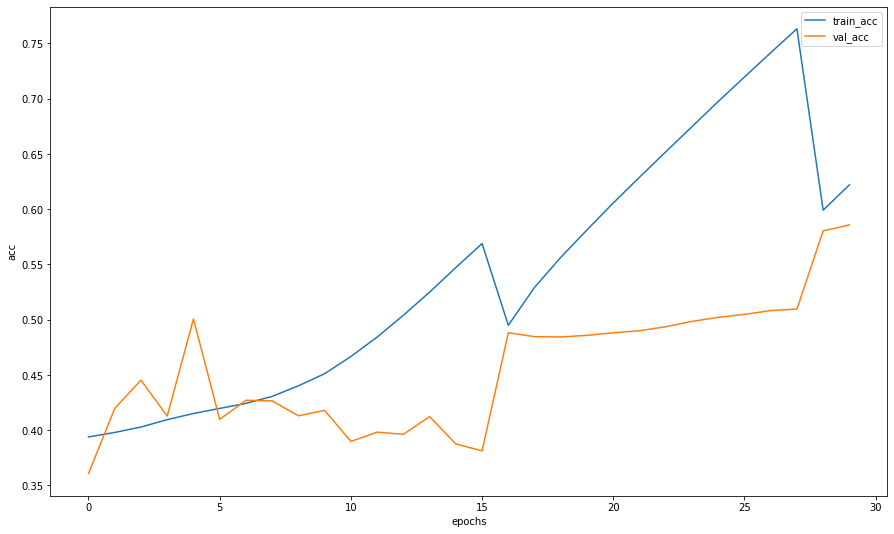

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

In [ ]:
torch.save(model_cnn_all.state_dict(), '/content/drive/MyDrive/GADF5_CNN.pth')

In [ ]:
model_cnn_all.load_state_dict(torch.load('/content/drive/MyDrive/GADF5_CNN.pth'))

<All keys matched successfully>

In [ ]:
y_pred_all = np.argmax(predict(model_cnn_all, test_loader), axis=1)

In [ ]:
accuracy_score(y_pred_all, y_test)

0.42805094761544416

In [ ]:
f1_score(y_test, y_pred_all, labels=[0, 1, 2], average=None)

array([0.55642367, 0.2599527 , 0.29387608])

In [ ]:
f1_score(y_test, y_pred_all, labels=[0, 1, 2], average='macro')

0.3700841490350613

In [ ]:
f1_score(y_test, y_pred_all, labels=[0, 1, 2], average='weighted')

0.4501327801910671

Confusion matrix, without normalization
[[70505 32780 42662]
 [19565 13079 13431]
 [17405  8692 17103]]


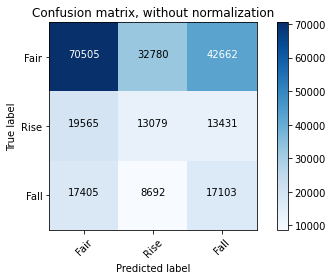

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred_all, labels=[0, 1, 2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=False, classes=['Fair', 'Rise', 'Fall'],
                      title='Confusion matrix, without normalization')

In [ ]:
history = train(train_dataset, val_dataset, model=model_cnn_all, epochs=20, batch_size=256)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 0.8276726766271638


epoch:   5%|▌         | 1/20 [00:47<15:01, 47.44s/it]


Epoch 001 train_loss: 0.8277     val_loss 1.1382 train_acc 0.6144 val_acc 0.4567
loss 0.8129499782054317


epoch:  10%|█         | 2/20 [01:33<14:07, 47.06s/it]


Epoch 002 train_loss: 0.8129     val_loss 1.1650 train_acc 0.6231 val_acc 0.4667
loss 0.771272998328905


epoch:  15%|█▌        | 3/20 [02:18<13:10, 46.50s/it]


Epoch 003 train_loss: 0.7713     val_loss 1.1884 train_acc 0.6466 val_acc 0.4718
loss 0.7266528823741528


epoch:  20%|██        | 4/20 [03:06<12:28, 46.76s/it]


Epoch 004 train_loss: 0.7267     val_loss 1.1900 train_acc 0.6718 val_acc 0.4780
loss 0.6855672981206078


epoch:  25%|██▌       | 5/20 [03:54<11:49, 47.28s/it]


Epoch 005 train_loss: 0.6856     val_loss 1.2261 train_acc 0.6934 val_acc 0.4793
loss 0.6475493287943503


epoch:  30%|███       | 6/20 [04:42<11:04, 47.48s/it]


Epoch 006 train_loss: 0.6475     val_loss 1.2921 train_acc 0.7131 val_acc 0.4852
loss 0.6137207136367717


epoch:  35%|███▌      | 7/20 [05:29<10:16, 47.41s/it]


Epoch 007 train_loss: 0.6137     val_loss 1.3351 train_acc 0.7304 val_acc 0.4909
loss 0.586009529077751


epoch:  40%|████      | 8/20 [06:16<09:25, 47.10s/it]


Epoch 008 train_loss: 0.5860     val_loss 1.3330 train_acc 0.7443 val_acc 0.4939
loss 0.5606343143841839


epoch:  45%|████▌     | 9/20 [07:02<08:33, 46.71s/it]


Epoch 009 train_loss: 0.5606     val_loss 1.3749 train_acc 0.7569 val_acc 0.4972
loss 0.5359497027829204


epoch:  50%|█████     | 10/20 [07:47<07:43, 46.38s/it]


Epoch 010 train_loss: 0.5359     val_loss 1.4008 train_acc 0.7694 val_acc 0.5020
loss 0.5142741898479039


epoch:  55%|█████▌    | 11/20 [08:33<06:57, 46.36s/it]


Epoch 011 train_loss: 0.5143     val_loss 1.3938 train_acc 0.7803 val_acc 0.5110
loss 0.4967329338633671


epoch:  60%|██████    | 12/20 [09:20<06:11, 46.41s/it]


Epoch 012 train_loss: 0.4967     val_loss 1.4284 train_acc 0.7886 val_acc 0.5066
loss 0.6601207096792717


epoch:  65%|██████▌   | 13/20 [10:07<05:25, 46.48s/it]


Epoch 013 train_loss: 0.6601     val_loss 1.0974 train_acc 0.7166 val_acc 0.5380
loss 0.5455523913502887


epoch:  70%|███████   | 14/20 [10:52<04:36, 46.15s/it]


Epoch 014 train_loss: 0.5456     val_loss 1.1886 train_acc 0.7732 val_acc 0.5410
loss 0.4588964881177814


epoch:  75%|███████▌  | 15/20 [11:37<03:49, 45.80s/it]


Epoch 015 train_loss: 0.4589     val_loss 1.3150 train_acc 0.8155 val_acc 0.5443
loss 0.3860470897343532


epoch:  80%|████████  | 16/20 [12:22<03:02, 45.63s/it]


Epoch 016 train_loss: 0.3860     val_loss 1.4945 train_acc 0.8503 val_acc 0.5460
loss 0.32267782175691795


epoch:  85%|████████▌ | 17/20 [13:07<02:16, 45.44s/it]


Epoch 017 train_loss: 0.3227     val_loss 1.7344 train_acc 0.8794 val_acc 0.5499
loss 0.2676527197769152


epoch:  90%|█████████ | 18/20 [13:52<01:30, 45.38s/it]


Epoch 018 train_loss: 0.2677     val_loss 2.0412 train_acc 0.9029 val_acc 0.5524
loss 0.2202285217337563


epoch:  95%|█████████▌| 19/20 [14:37<00:45, 45.26s/it]


Epoch 019 train_loss: 0.2202     val_loss 2.4202 train_acc 0.9214 val_acc 0.5574
loss 0.18112094282603114


epoch: 100%|██████████| 20/20 [15:23<00:00, 46.17s/it]


Epoch 020 train_loss: 0.1811     val_loss 2.8644 train_acc 0.9356 val_acc 0.5619


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

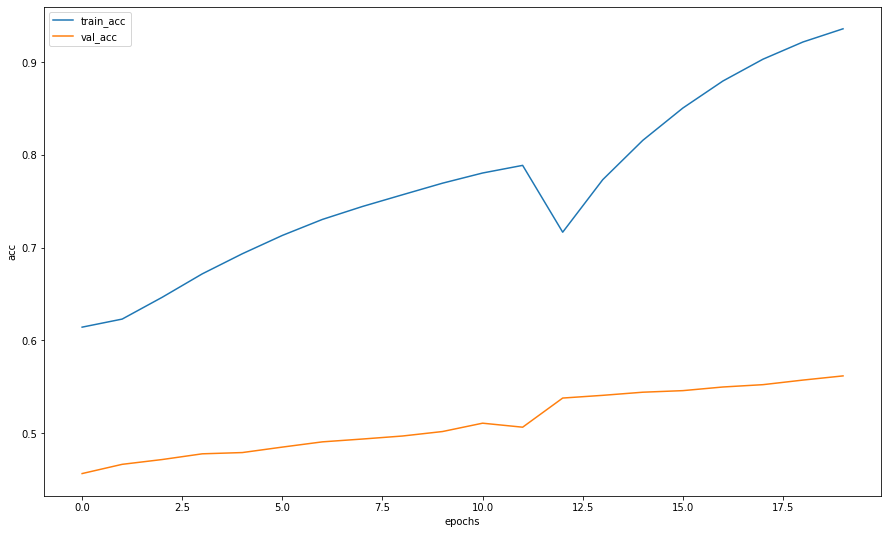

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

In [ ]:
y_pred_all = np.argmax(predict(model_cnn_all, test_loader), axis=1)

Confusion matrix, without normalization
[[60163 41932 43852]
 [16202 16264 13609]
 [14226 11465 17509]]


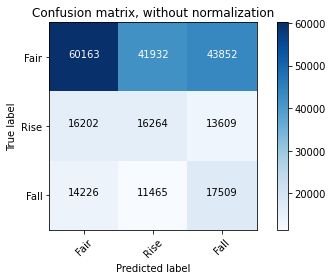

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred_all, labels=[0, 1, 2])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=False, classes=['Fair', 'Rise', 'Fall'],
                      title='Confusion matrix, without normalization')

In [ ]:
accuracy_score(y_pred_all, y_test)

0.3993504008978752

In [ ]:
f1_score(y_test, y_pred_all, labels=[0, 1, 2], average=None)

array([0.51, 0.28, 0.3 ])

In [ ]:
f1_score(y_test, y_pred_all, labels=[0, 1, 2], average='macro')

0.3620284988348054

In [ ]:
f1_score(y_test, y_pred_all, labels=[0, 1, 2], average='weighted')

0.42510453296127215

In [ ]:
torch.save(model_cnn_all.state_dict(), '/content/drive/MyDrive/GADF5_50_CNN.pth')

In [ ]:
model_cnn_all.load_state_dict(torch.load('/content/drive/MyDrive/GADF5_50_CNN.pth'))

<All keys matched successfully>